In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 400 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 4

maximum steps, simulation is done ... 
elapsed_time: 6.645
Episode: 1 Exploration P: 1.0000 Total reward: -1504.2285436709128 SOC: 1.0000 Cumulative_SOC_deviation: 351.0103 Fuel Consumption: 100.1872

maximum steps, simulation is done ... 
elapsed_time: 6.553
Episode: 2 Exploration P: 1.0000 Total reward: -1499.8759913314896 SOC: 1.0000 Cumulative_SOC_deviation: 350.0615 Fuel Consumption: 99.6300



C:\Users\RECL\Desktop\Song\graduate_paper\program\experiment\DDPG_rewardfactor_comparison\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 6.487
Episode: 3 Exploration P: 1.0000 Total reward: -1510.5437732683952 SOC: 1.0000 Cumulative_SOC_deviation: 352.5324 Fuel Consumption: 100.4142

maximum steps, simulation is done ... 
elapsed_time: 6.590
Episode: 4 Exploration P: 1.0000 Total reward: -1521.0108181811227 SOC: 1.0000 Cumulative_SOC_deviation: 354.4114 Fuel Consumption: 103.3652


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warni

C:\Users\RECL\Desktop\Song\graduate_paper\program\experiment\DDPG_rewardfactor_comparison\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 49.026
Episode: 6 Exploration P: 0.9803 Total reward: -1519.567371549363 SOC: 1.0000 Cumulative_SOC_deviation: 354.0296 Fuel Consumption: 103.4490

maximum steps, simulation is done ... 
elapsed_time: 49.267
Episode: 7 Exploration P: 0.9611 Total reward: -1468.8599933082291 SOC: 1.0000 Cumulative_SOC_deviation: 330.4339 Fuel Consumption: 147.1244

maximum steps, simulation is done ... 
elapsed_time: 49.406
Episode: 8 Exploration P: 0.9422 Total reward: -1511.8182919609649 SOC: 1.0000 Cumulative_SOC_deviation: 353.1245 Fuel Consumption: 99.3204

maximum steps, simulation is done ... 
elapsed_time: 49.417
Episode: 9 Exploration P: 0.9237 Total reward: -1468.2940863476158 SOC: 1.0000 Cumulative_SOC_deviation: 343.5048 Fuel Consumption: 94.2749

maximum steps, simulation is done ... 
elapsed_time: 49.874
Episode: 10 Exploration P: 0.9056 Total reward: -1499.1017508396117 SOC: 1.0000 Cumulative_SOC_deviation: 350.9797 Fuel Consumption: 95

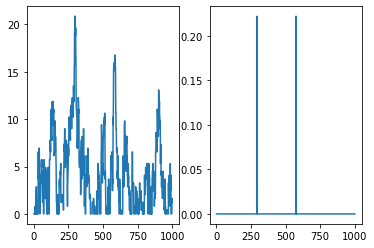

maximum steps, simulation is done ... 
elapsed_time: 49.223
Episode: 11 Exploration P: 0.8879 Total reward: -1487.1952901355826 SOC: 1.0000 Cumulative_SOC_deviation: 348.2611 Fuel Consumption: 94.1511

maximum steps, simulation is done ... 
elapsed_time: 49.916
Episode: 12 Exploration P: 0.8705 Total reward: -1481.961703444947 SOC: 1.0000 Cumulative_SOC_deviation: 347.9484 Fuel Consumption: 90.1683

maximum steps, simulation is done ... 
elapsed_time: 51.218
Episode: 13 Exploration P: 0.8534 Total reward: -1462.9441617770058 SOC: 1.0000 Cumulative_SOC_deviation: 343.2327 Fuel Consumption: 90.0135

maximum steps, simulation is done ... 
elapsed_time: 50.841
Episode: 14 Exploration P: 0.8367 Total reward: -1473.0974337579025 SOC: 1.0000 Cumulative_SOC_deviation: 345.9980 Fuel Consumption: 89.1055

maximum steps, simulation is done ... 
elapsed_time: 50.050
Episode: 15 Exploration P: 0.8203 Total reward: -1437.5484165829346 SOC: 1.0000 Cumulative_SOC_deviation: 337.9646 Fuel Consumption: 

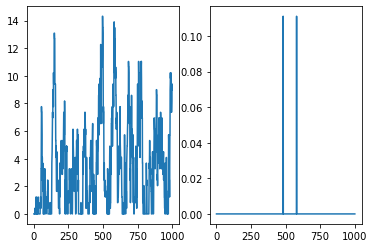

maximum steps, simulation is done ... 
elapsed_time: 50.208
Episode: 21 Exploration P: 0.7286 Total reward: -1402.8225394891642 SOC: 1.0000 Cumulative_SOC_deviation: 330.2375 Fuel Consumption: 81.8725

maximum steps, simulation is done ... 
elapsed_time: 50.576
Episode: 22 Exploration P: 0.7144 Total reward: -1388.9311308535964 SOC: 0.9949 Cumulative_SOC_deviation: 326.1172 Fuel Consumption: 84.4623

maximum steps, simulation is done ... 
elapsed_time: 50.462
Episode: 23 Exploration P: 0.7004 Total reward: -1427.585004980994 SOC: 1.0000 Cumulative_SOC_deviation: 337.6869 Fuel Consumption: 76.8372

maximum steps, simulation is done ... 
elapsed_time: 50.062
Episode: 24 Exploration P: 0.6867 Total reward: -1400.1930425249063 SOC: 0.9966 Cumulative_SOC_deviation: 331.1898 Fuel Consumption: 75.4340

maximum steps, simulation is done ... 
elapsed_time: 50.213
Episode: 25 Exploration P: 0.6733 Total reward: -1441.5863285095825 SOC: 1.0000 Cumulative_SOC_deviation: 341.8089 Fuel Consumption: 

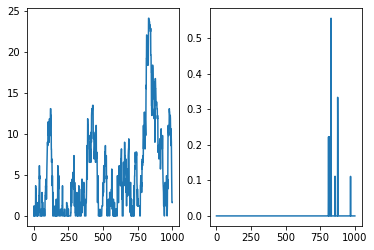

maximum steps, simulation is done ... 
elapsed_time: 49.330
Episode: 31 Exploration P: 0.5982 Total reward: -1365.5099328211893 SOC: 1.0000 Cumulative_SOC_deviation: 324.9592 Fuel Consumption: 65.6730

maximum steps, simulation is done ... 
elapsed_time: 50.279
Episode: 32 Exploration P: 0.5866 Total reward: -1338.8430746334984 SOC: 1.0000 Cumulative_SOC_deviation: 318.2822 Fuel Consumption: 65.7143

maximum steps, simulation is done ... 
elapsed_time: 50.341
Episode: 33 Exploration P: 0.5751 Total reward: -1321.6903122137237 SOC: 0.9990 Cumulative_SOC_deviation: 314.8117 Fuel Consumption: 62.4434

maximum steps, simulation is done ... 
elapsed_time: 50.279
Episode: 34 Exploration P: 0.5639 Total reward: -1053.9936692285025 SOC: 0.9996 Cumulative_SOC_deviation: 244.4336 Fuel Consumption: 76.2594

maximum steps, simulation is done ... 
elapsed_time: 50.604
Episode: 35 Exploration P: 0.5530 Total reward: -1304.7084029007992 SOC: 0.9999 Cumulative_SOC_deviation: 310.8887 Fuel Consumption:

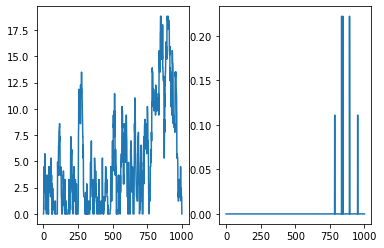

maximum steps, simulation is done ... 
elapsed_time: 48.977
Episode: 41 Exploration P: 0.4915 Total reward: -1236.0888543162284 SOC: 1.0000 Cumulative_SOC_deviation: 294.0511 Fuel Consumption: 59.8845

maximum steps, simulation is done ... 
elapsed_time: 50.529
Episode: 42 Exploration P: 0.4820 Total reward: -1199.3435950988346 SOC: 1.0000 Cumulative_SOC_deviation: 285.2981 Fuel Consumption: 58.1511

maximum steps, simulation is done ... 
elapsed_time: 50.640
Episode: 43 Exploration P: 0.4726 Total reward: -1269.649235766483 SOC: 1.0000 Cumulative_SOC_deviation: 303.4627 Fuel Consumption: 55.7985

maximum steps, simulation is done ... 
elapsed_time: 50.470
Episode: 44 Exploration P: 0.4634 Total reward: -1228.656696964564 SOC: 1.0000 Cumulative_SOC_deviation: 293.5241 Fuel Consumption: 54.5604

maximum steps, simulation is done ... 
elapsed_time: 50.212
Episode: 45 Exploration P: 0.4544 Total reward: -1201.9883784943868 SOC: 0.9987 Cumulative_SOC_deviation: 286.5088 Fuel Consumption: 5

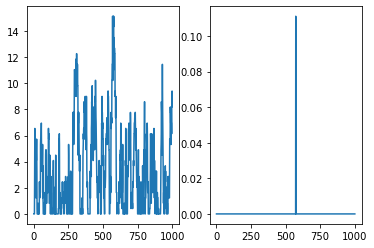

maximum steps, simulation is done ... 
elapsed_time: 49.310
Episode: 51 Exploration P: 0.4041 Total reward: -1118.446454678484 SOC: 0.9955 Cumulative_SOC_deviation: 266.2166 Fuel Consumption: 53.5801

maximum steps, simulation is done ... 
elapsed_time: 50.683
Episode: 52 Exploration P: 0.3963 Total reward: -966.4271971269109 SOC: 0.9659 Cumulative_SOC_deviation: 225.8850 Fuel Consumption: 62.8871

maximum steps, simulation is done ... 
elapsed_time: 50.952
Episode: 53 Exploration P: 0.3887 Total reward: -1052.8071790613249 SOC: 1.0000 Cumulative_SOC_deviation: 251.7466 Fuel Consumption: 45.8209

maximum steps, simulation is done ... 
elapsed_time: 50.510
Episode: 54 Exploration P: 0.3812 Total reward: -971.2780472239301 SOC: 0.8811 Cumulative_SOC_deviation: 228.9473 Fuel Consumption: 55.4890

maximum steps, simulation is done ... 
elapsed_time: 50.502
Episode: 55 Exploration P: 0.3738 Total reward: -843.3356939831301 SOC: 0.9247 Cumulative_SOC_deviation: 197.7407 Fuel Consumption: 52.

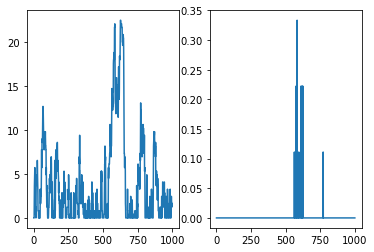

maximum steps, simulation is done ... 
elapsed_time: 49.477
Episode: 61 Exploration P: 0.3326 Total reward: -978.1354938786429 SOC: 1.0000 Cumulative_SOC_deviation: 234.4355 Fuel Consumption: 40.3936

maximum steps, simulation is done ... 
elapsed_time: 50.944
Episode: 62 Exploration P: 0.3262 Total reward: -921.9220002283588 SOC: 0.9322 Cumulative_SOC_deviation: 219.3580 Fuel Consumption: 44.4899

maximum steps, simulation is done ... 
elapsed_time: 51.219
Episode: 63 Exploration P: 0.3200 Total reward: -928.7677477285554 SOC: 0.9909 Cumulative_SOC_deviation: 221.9878 Fuel Consumption: 40.8166

maximum steps, simulation is done ... 
elapsed_time: 50.633
Episode: 64 Exploration P: 0.3138 Total reward: -940.3112600294209 SOC: 1.0000 Cumulative_SOC_deviation: 224.2520 Fuel Consumption: 43.3033

maximum steps, simulation is done ... 
elapsed_time: 50.880
Episode: 65 Exploration P: 0.3078 Total reward: -497.61164581132147 SOC: 0.8774 Cumulative_SOC_deviation: 113.8015 Fuel Consumption: 42.

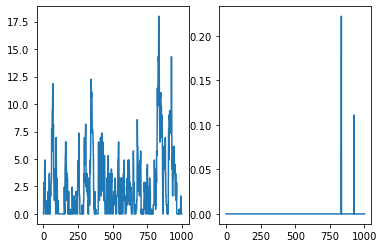

maximum steps, simulation is done ... 
elapsed_time: 49.988
Episode: 71 Exploration P: 0.2741 Total reward: -817.512765943609 SOC: 0.9565 Cumulative_SOC_deviation: 195.4767 Fuel Consumption: 35.6059

maximum steps, simulation is done ... 
elapsed_time: 50.791
Episode: 72 Exploration P: 0.2689 Total reward: -825.7061900524874 SOC: 0.9714 Cumulative_SOC_deviation: 197.5844 Fuel Consumption: 35.3686

maximum steps, simulation is done ... 
elapsed_time: 50.786
Episode: 73 Exploration P: 0.2637 Total reward: -781.0247710987895 SOC: 0.9415 Cumulative_SOC_deviation: 186.0555 Fuel Consumption: 36.8028

maximum steps, simulation is done ... 
elapsed_time: 50.603
Episode: 74 Exploration P: 0.2587 Total reward: -723.0493387564368 SOC: 0.9395 Cumulative_SOC_deviation: 171.3269 Fuel Consumption: 37.7418

maximum steps, simulation is done ... 
elapsed_time: 50.854
Episode: 75 Exploration P: 0.2538 Total reward: -774.0156467859118 SOC: 0.9408 Cumulative_SOC_deviation: 184.5689 Fuel Consumption: 35.74

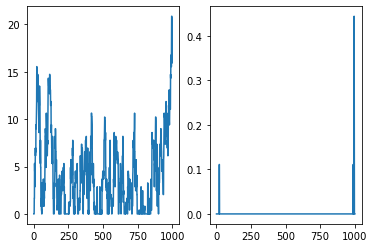

maximum steps, simulation is done ... 
elapsed_time: 51.124
Episode: 81 Exploration P: 0.2262 Total reward: -516.58220977623 SOC: 0.8269 Cumulative_SOC_deviation: 120.7883 Fuel Consumption: 33.4288

maximum steps, simulation is done ... 
elapsed_time: 52.101
Episode: 82 Exploration P: 0.2219 Total reward: -404.3855287277858 SOC: 0.8241 Cumulative_SOC_deviation: 93.1467 Fuel Consumption: 31.7986

maximum steps, simulation is done ... 
elapsed_time: 51.797
Episode: 83 Exploration P: 0.2177 Total reward: -522.7295162501795 SOC: 0.8467 Cumulative_SOC_deviation: 123.1584 Fuel Consumption: 30.0961

maximum steps, simulation is done ... 
elapsed_time: 51.222
Episode: 84 Exploration P: 0.2136 Total reward: -729.8899603134486 SOC: 0.9279 Cumulative_SOC_deviation: 173.6897 Fuel Consumption: 35.1313

maximum steps, simulation is done ... 
elapsed_time: 51.206
Episode: 85 Exploration P: 0.2095 Total reward: -653.2295751598432 SOC: 0.9190 Cumulative_SOC_deviation: 154.8805 Fuel Consumption: 33.7074

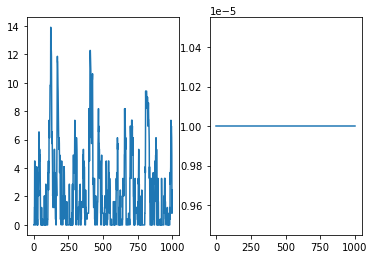

maximum steps, simulation is done ... 
elapsed_time: 50.972
Episode: 91 Exploration P: 0.1870 Total reward: -214.53080773299192 SOC: 0.7337 Cumulative_SOC_deviation: 45.9771 Fuel Consumption: 30.6223

maximum steps, simulation is done ... 
elapsed_time: 51.080
Episode: 92 Exploration P: 0.1834 Total reward: -634.2468383336918 SOC: 0.8696 Cumulative_SOC_deviation: 151.1357 Fuel Consumption: 29.7040

maximum steps, simulation is done ... 
elapsed_time: 50.896
Episode: 93 Exploration P: 0.1800 Total reward: -586.2570852704974 SOC: 0.8375 Cumulative_SOC_deviation: 139.9663 Fuel Consumption: 26.3918

maximum steps, simulation is done ... 
elapsed_time: 51.057
Episode: 94 Exploration P: 0.1766 Total reward: -511.79238158513925 SOC: 0.8311 Cumulative_SOC_deviation: 121.5255 Fuel Consumption: 25.6902

maximum steps, simulation is done ... 
elapsed_time: 51.027
Episode: 95 Exploration P: 0.1733 Total reward: -465.4758566987143 SOC: 0.8168 Cumulative_SOC_deviation: 109.9903 Fuel Consumption: 25.

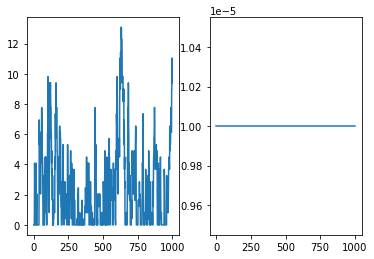

maximum steps, simulation is done ... 
elapsed_time: 51.151
Episode: 101 Exploration P: 0.1549 Total reward: -147.1851368381585 SOC: 0.6839 Cumulative_SOC_deviation: 30.9438 Fuel Consumption: 23.4099

maximum steps, simulation is done ... 
elapsed_time: 51.114
Episode: 102 Exploration P: 0.1520 Total reward: -260.7619759635574 SOC: 0.7399 Cumulative_SOC_deviation: 59.4773 Fuel Consumption: 22.8527

maximum steps, simulation is done ... 
elapsed_time: 51.431
Episode: 103 Exploration P: 0.1492 Total reward: -432.78609003674507 SOC: 0.8108 Cumulative_SOC_deviation: 102.2357 Fuel Consumption: 23.8433

maximum steps, simulation is done ... 
elapsed_time: 51.082
Episode: 104 Exploration P: 0.1464 Total reward: -171.50301480948488 SOC: 0.7064 Cumulative_SOC_deviation: 36.7498 Fuel Consumption: 24.5036

maximum steps, simulation is done ... 
elapsed_time: 50.890
Episode: 105 Exploration P: 0.1437 Total reward: -386.2537720056131 SOC: 0.7716 Cumulative_SOC_deviation: 91.5338 Fuel Consumption: 2

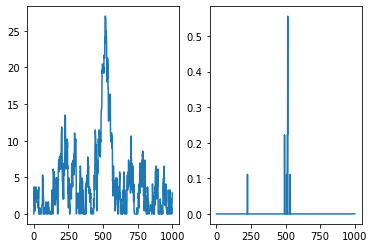

maximum steps, simulation is done ... 
elapsed_time: 51.108
Episode: 111 Exploration P: 0.1286 Total reward: -315.9307264323772 SOC: 0.7483 Cumulative_SOC_deviation: 74.3168 Fuel Consumption: 18.6636

maximum steps, simulation is done ... 
elapsed_time: 50.715
Episode: 112 Exploration P: 0.1262 Total reward: -310.13109046039585 SOC: 0.7352 Cumulative_SOC_deviation: 72.5315 Fuel Consumption: 20.0049

maximum steps, simulation is done ... 
elapsed_time: 50.673
Episode: 113 Exploration P: 0.1239 Total reward: -350.5400253935881 SOC: 0.7385 Cumulative_SOC_deviation: 82.3526 Fuel Consumption: 21.1296

maximum steps, simulation is done ... 
elapsed_time: 50.780
Episode: 114 Exploration P: 0.1217 Total reward: -132.98895098145562 SOC: 0.6552 Cumulative_SOC_deviation: 28.7774 Fuel Consumption: 17.8794

maximum steps, simulation is done ... 
elapsed_time: 51.108
Episode: 115 Exploration P: 0.1194 Total reward: -144.81812245975001 SOC: 0.6510 Cumulative_SOC_deviation: 31.4587 Fuel Consumption: 1

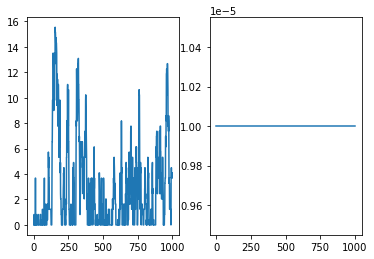

maximum steps, simulation is done ... 
elapsed_time: 51.182
Episode: 121 Exploration P: 0.1071 Total reward: -264.7813324921992 SOC: 0.6343 Cumulative_SOC_deviation: 62.0299 Fuel Consumption: 16.6618

maximum steps, simulation is done ... 
elapsed_time: 51.072
Episode: 122 Exploration P: 0.1051 Total reward: -254.34620668630777 SOC: 0.7058 Cumulative_SOC_deviation: 59.6068 Fuel Consumption: 15.9189

maximum steps, simulation is done ... 
elapsed_time: 51.015
Episode: 123 Exploration P: 0.1032 Total reward: -151.08430830940392 SOC: 0.6717 Cumulative_SOC_deviation: 33.8094 Fuel Consumption: 15.8467

maximum steps, simulation is done ... 
elapsed_time: 51.149
Episode: 124 Exploration P: 0.1014 Total reward: -117.55207643815231 SOC: 0.6455 Cumulative_SOC_deviation: 26.8657 Fuel Consumption: 10.0892

maximum steps, simulation is done ... 
elapsed_time: 51.374
Episode: 125 Exploration P: 0.0996 Total reward: -90.06906970334603 SOC: 0.5793 Cumulative_SOC_deviation: 19.3939 Fuel Consumption: 1

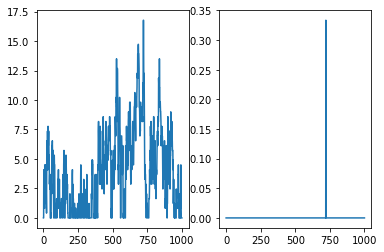

maximum steps, simulation is done ... 
elapsed_time: 51.045
Episode: 131 Exploration P: 0.0894 Total reward: -261.47307415875173 SOC: 0.4396 Cumulative_SOC_deviation: 60.4625 Fuel Consumption: 19.6231

maximum steps, simulation is done ... 
elapsed_time: 51.062
Episode: 132 Exploration P: 0.0879 Total reward: -208.98798554653987 SOC: 0.6542 Cumulative_SOC_deviation: 48.4556 Fuel Consumption: 15.1657

maximum steps, simulation is done ... 
elapsed_time: 50.979
Episode: 133 Exploration P: 0.0863 Total reward: -155.22558916700214 SOC: 0.6241 Cumulative_SOC_deviation: 34.6590 Fuel Consumption: 16.5896

maximum steps, simulation is done ... 
elapsed_time: 50.867
Episode: 134 Exploration P: 0.0848 Total reward: -57.05417922217938 SOC: 0.6145 Cumulative_SOC_deviation: 11.6716 Fuel Consumption: 10.3678

maximum steps, simulation is done ... 
elapsed_time: 50.926
Episode: 135 Exploration P: 0.0833 Total reward: -64.22457742095834 SOC: 0.6325 Cumulative_SOC_deviation: 13.4436 Fuel Consumption: 1

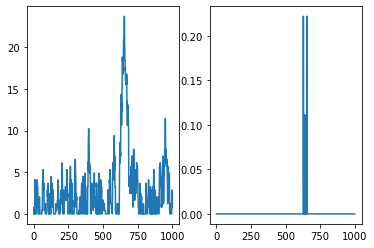

maximum steps, simulation is done ... 
elapsed_time: 50.817
Episode: 141 Exploration P: 0.0750 Total reward: -89.68196739823355 SOC: 0.5978 Cumulative_SOC_deviation: 19.7254 Fuel Consumption: 10.7805

maximum steps, simulation is done ... 
elapsed_time: 51.154
Episode: 142 Exploration P: 0.0737 Total reward: -200.04150876511582 SOC: 0.3803 Cumulative_SOC_deviation: 45.7598 Fuel Consumption: 17.0023

maximum steps, simulation is done ... 
elapsed_time: 51.030
Episode: 143 Exploration P: 0.0725 Total reward: -100.53024709830642 SOC: 0.5802 Cumulative_SOC_deviation: 22.8734 Fuel Consumption: 9.0367

maximum steps, simulation is done ... 
elapsed_time: 51.044
Episode: 144 Exploration P: 0.0712 Total reward: -61.41831085304233 SOC: 0.6376 Cumulative_SOC_deviation: 12.4557 Fuel Consumption: 11.5956

maximum steps, simulation is done ... 
elapsed_time: 50.888
Episode: 145 Exploration P: 0.0700 Total reward: -80.89063793339983 SOC: 0.6019 Cumulative_SOC_deviation: 16.8182 Fuel Consumption: 13.

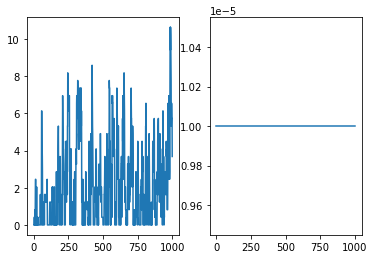

maximum steps, simulation is done ... 
elapsed_time: 51.424
Episode: 151 Exploration P: 0.0632 Total reward: -52.58447493894179 SOC: 0.5682 Cumulative_SOC_deviation: 11.0443 Fuel Consumption: 8.4073

maximum steps, simulation is done ... 
elapsed_time: 51.281
Episode: 152 Exploration P: 0.0622 Total reward: -75.5564805944363 SOC: 0.5764 Cumulative_SOC_deviation: 16.3926 Fuel Consumption: 9.9860

maximum steps, simulation is done ... 
elapsed_time: 51.606
Episode: 153 Exploration P: 0.0611 Total reward: -103.33957622966675 SOC: 0.5774 Cumulative_SOC_deviation: 23.7202 Fuel Consumption: 8.4589

maximum steps, simulation is done ... 
elapsed_time: 51.267
Episode: 154 Exploration P: 0.0601 Total reward: -90.08097382734512 SOC: 0.5619 Cumulative_SOC_deviation: 19.8844 Fuel Consumption: 10.5432

maximum steps, simulation is done ... 
elapsed_time: 51.964
Episode: 155 Exploration P: 0.0591 Total reward: -756.1071214812574 SOC: 0.3066 Cumulative_SOC_deviation: 185.4881 Fuel Consumption: 14.154

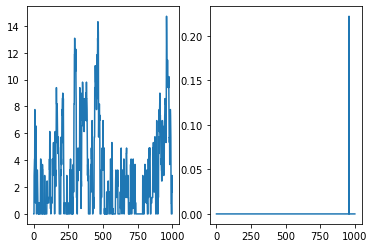

maximum steps, simulation is done ... 
elapsed_time: 51.236
Episode: 161 Exploration P: 0.0536 Total reward: -647.1700820388751 SOC: 0.3687 Cumulative_SOC_deviation: 159.3141 Fuel Consumption: 9.9138

maximum steps, simulation is done ... 
elapsed_time: 51.379
Episode: 162 Exploration P: 0.0527 Total reward: -102.15275449355615 SOC: 0.5813 Cumulative_SOC_deviation: 23.2558 Fuel Consumption: 9.1296

maximum steps, simulation is done ... 
elapsed_time: 51.827
Episode: 163 Exploration P: 0.0519 Total reward: -217.66575691758683 SOC: 0.5216 Cumulative_SOC_deviation: 51.8271 Fuel Consumption: 10.3575

maximum steps, simulation is done ... 
elapsed_time: 51.357
Episode: 164 Exploration P: 0.0510 Total reward: -193.13761879890296 SOC: 0.5233 Cumulative_SOC_deviation: 45.4113 Fuel Consumption: 11.4925

maximum steps, simulation is done ... 
elapsed_time: 51.413
Episode: 165 Exploration P: 0.0502 Total reward: -93.91505013329203 SOC: 0.5376 Cumulative_SOC_deviation: 21.4569 Fuel Consumption: 8.

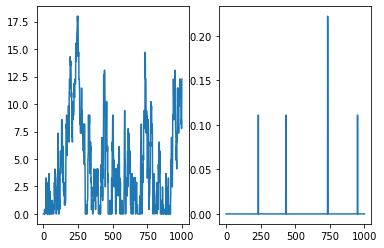

maximum steps, simulation is done ... 
elapsed_time: 51.142
Episode: 171 Exploration P: 0.0457 Total reward: -146.49199399256625 SOC: 0.5407 Cumulative_SOC_deviation: 34.9571 Fuel Consumption: 6.6636

maximum steps, simulation is done ... 
elapsed_time: 51.257
Episode: 172 Exploration P: 0.0450 Total reward: -57.63341275207598 SOC: 0.5838 Cumulative_SOC_deviation: 12.2730 Fuel Consumption: 8.5415

maximum steps, simulation is done ... 
elapsed_time: 51.031
Episode: 173 Exploration P: 0.0443 Total reward: -118.10430928726872 SOC: 0.5454 Cumulative_SOC_deviation: 28.1285 Fuel Consumption: 5.5905

maximum steps, simulation is done ... 
elapsed_time: 51.032
Episode: 174 Exploration P: 0.0436 Total reward: -314.36998700234045 SOC: 0.4681 Cumulative_SOC_deviation: 77.0220 Fuel Consumption: 6.2818

maximum steps, simulation is done ... 
elapsed_time: 50.692
Episode: 175 Exploration P: 0.0429 Total reward: -65.41465271258146 SOC: 0.5818 Cumulative_SOC_deviation: 14.6413 Fuel Consumption: 6.849

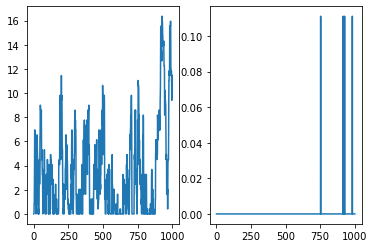

maximum steps, simulation is done ... 
elapsed_time: 51.068
Episode: 181 Exploration P: 0.0392 Total reward: -92.75576460614245 SOC: 0.5659 Cumulative_SOC_deviation: 21.9719 Fuel Consumption: 4.8682

maximum steps, simulation is done ... 
elapsed_time: 50.938
Episode: 182 Exploration P: 0.0386 Total reward: -124.03776327242868 SOC: 0.5461 Cumulative_SOC_deviation: 28.9489 Fuel Consumption: 8.2422

maximum steps, simulation is done ... 
elapsed_time: 50.897
Episode: 183 Exploration P: 0.0381 Total reward: -45.00184350265287 SOC: 0.5705 Cumulative_SOC_deviation: 9.4556 Fuel Consumption: 7.1795

maximum steps, simulation is done ... 
elapsed_time: 51.268
Episode: 184 Exploration P: 0.0375 Total reward: -154.29159824958919 SOC: 0.5517 Cumulative_SOC_deviation: 37.1443 Fuel Consumption: 5.7143

maximum steps, simulation is done ... 
elapsed_time: 51.098
Episode: 185 Exploration P: 0.0370 Total reward: -156.65907197790185 SOC: 0.5418 Cumulative_SOC_deviation: 37.5273 Fuel Consumption: 6.5501

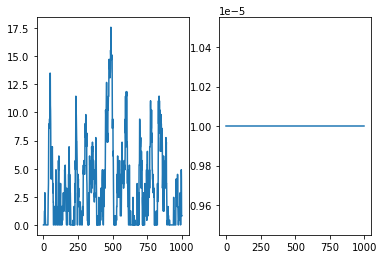

maximum steps, simulation is done ... 
elapsed_time: 50.785
Episode: 191 Exploration P: 0.0339 Total reward: -161.6837062530296 SOC: 0.5507 Cumulative_SOC_deviation: 39.2090 Fuel Consumption: 4.8476

maximum steps, simulation is done ... 
elapsed_time: 51.330
Episode: 192 Exploration P: 0.0334 Total reward: -242.62129139227008 SOC: 0.4935 Cumulative_SOC_deviation: 59.2758 Fuel Consumption: 5.5183

maximum steps, simulation is done ... 
elapsed_time: 51.219
Episode: 193 Exploration P: 0.0330 Total reward: -297.759061413693 SOC: 0.4701 Cumulative_SOC_deviation: 73.6148 Fuel Consumption: 3.2999

maximum steps, simulation is done ... 
elapsed_time: 51.316
Episode: 194 Exploration P: 0.0325 Total reward: -225.54386255152292 SOC: 0.4806 Cumulative_SOC_deviation: 55.1741 Fuel Consumption: 4.8476

maximum steps, simulation is done ... 
elapsed_time: 50.654
Episode: 195 Exploration P: 0.0321 Total reward: -333.4262038450346 SOC: 0.4619 Cumulative_SOC_deviation: 82.3588 Fuel Consumption: 3.9912


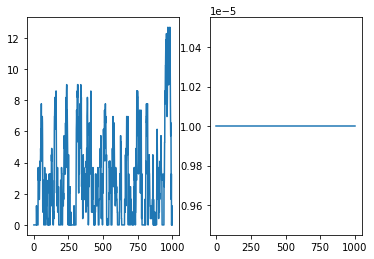

maximum steps, simulation is done ... 
elapsed_time: 51.308
Episode: 201 Exploration P: 0.0296 Total reward: -457.1492539650199 SOC: 0.2932 Cumulative_SOC_deviation: 111.8269 Fuel Consumption: 9.8416

maximum steps, simulation is done ... 
elapsed_time: 51.119
Episode: 202 Exploration P: 0.0292 Total reward: -501.3823733793011 SOC: 0.4249 Cumulative_SOC_deviation: 123.6720 Fuel Consumption: 6.6945

maximum steps, simulation is done ... 
elapsed_time: 51.212
Episode: 203 Exploration P: 0.0288 Total reward: -499.2643653579251 SOC: 0.3805 Cumulative_SOC_deviation: 123.0419 Fuel Consumption: 7.0969

maximum steps, simulation is done ... 
elapsed_time: 51.149
Episode: 204 Exploration P: 0.0284 Total reward: -114.50828729351467 SOC: 0.5307 Cumulative_SOC_deviation: 27.7376 Fuel Consumption: 3.5578

maximum steps, simulation is done ... 
elapsed_time: 51.136
Episode: 205 Exploration P: 0.0281 Total reward: -126.47216635719923 SOC: 0.4808 Cumulative_SOC_deviation: 30.3365 Fuel Consumption: 5.1

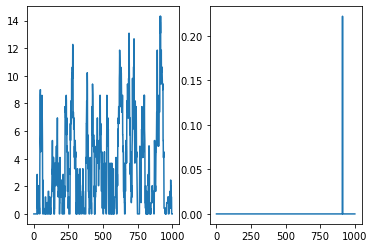

maximum steps, simulation is done ... 
elapsed_time: 50.930
Episode: 211 Exploration P: 0.0260 Total reward: -204.70210539905776 SOC: 0.4796 Cumulative_SOC_deviation: 50.3738 Fuel Consumption: 3.2070

maximum steps, simulation is done ... 
elapsed_time: 50.741
Episode: 212 Exploration P: 0.0257 Total reward: -117.53140689469207 SOC: 0.5429 Cumulative_SOC_deviation: 28.8674 Fuel Consumption: 2.0617

maximum steps, simulation is done ... 
elapsed_time: 50.882
Episode: 213 Exploration P: 0.0254 Total reward: -219.40192546315035 SOC: 0.4784 Cumulative_SOC_deviation: 53.7495 Fuel Consumption: 4.4039

maximum steps, simulation is done ... 
elapsed_time: 50.863
Episode: 214 Exploration P: 0.0251 Total reward: -242.19347206447145 SOC: 0.5035 Cumulative_SOC_deviation: 59.1559 Fuel Consumption: 5.5698

maximum steps, simulation is done ... 
elapsed_time: 51.062
Episode: 215 Exploration P: 0.0248 Total reward: -663.0394821807333 SOC: 0.3357 Cumulative_SOC_deviation: 164.5454 Fuel Consumption: 4.8

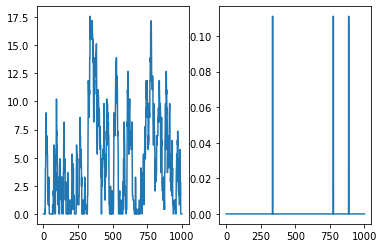

maximum steps, simulation is done ... 
elapsed_time: 51.081
Episode: 221 Exploration P: 0.0231 Total reward: -1050.1664175424867 SOC: 0.2469 Cumulative_SOC_deviation: 260.4501 Fuel Consumption: 8.3661

maximum steps, simulation is done ... 
elapsed_time: 51.017
Episode: 222 Exploration P: 0.0228 Total reward: -302.1606600244229 SOC: 0.4333 Cumulative_SOC_deviation: 74.6223 Fuel Consumption: 3.6713

maximum steps, simulation is done ... 
elapsed_time: 52.969
Episode: 223 Exploration P: 0.0226 Total reward: -271.3504671316356 SOC: 0.4635 Cumulative_SOC_deviation: 67.3351 Fuel Consumption: 2.0101

maximum steps, simulation is done ... 
elapsed_time: 50.972
Episode: 224 Exploration P: 0.0223 Total reward: -388.5022753436815 SOC: 0.4350 Cumulative_SOC_deviation: 96.0427 Fuel Consumption: 4.3317

maximum steps, simulation is done ... 
elapsed_time: 51.049
Episode: 225 Exploration P: 0.0221 Total reward: -124.45350495101117 SOC: 0.5404 Cumulative_SOC_deviation: 30.4071 Fuel Consumption: 2.825

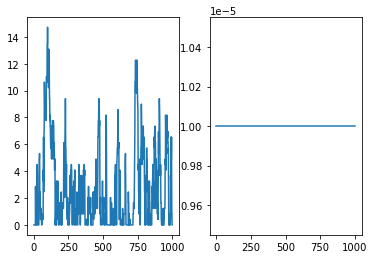

maximum steps, simulation is done ... 
elapsed_time: 51.637
Episode: 231 Exploration P: 0.0207 Total reward: -310.3006750945695 SOC: 0.4395 Cumulative_SOC_deviation: 76.9978 Fuel Consumption: 2.3093

maximum steps, simulation is done ... 
elapsed_time: 51.028
Episode: 232 Exploration P: 0.0205 Total reward: -412.51698829625917 SOC: 0.4687 Cumulative_SOC_deviation: 101.2389 Fuel Consumption: 7.5612

maximum steps, simulation is done ... 
elapsed_time: 51.184
Episode: 233 Exploration P: 0.0203 Total reward: -148.4295319710684 SOC: 0.5140 Cumulative_SOC_deviation: 36.1947 Fuel Consumption: 3.6507

maximum steps, simulation is done ... 
elapsed_time: 51.173
Episode: 234 Exploration P: 0.0201 Total reward: -178.53023114229228 SOC: 0.5090 Cumulative_SOC_deviation: 43.6477 Fuel Consumption: 3.9396

maximum steps, simulation is done ... 
elapsed_time: 51.045
Episode: 235 Exploration P: 0.0199 Total reward: -166.0605680729609 SOC: 0.5195 Cumulative_SOC_deviation: 40.8682 Fuel Consumption: 2.587

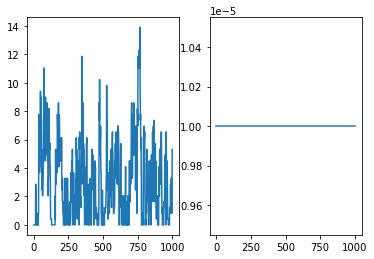

maximum steps, simulation is done ... 
elapsed_time: 50.987
Episode: 241 Exploration P: 0.0188 Total reward: -294.9417815355666 SOC: 0.4442 Cumulative_SOC_deviation: 72.4049 Fuel Consumption: 5.3222

maximum steps, simulation is done ... 
elapsed_time: 50.969
Episode: 242 Exploration P: 0.0186 Total reward: -345.8235659040633 SOC: 0.4341 Cumulative_SOC_deviation: 85.7161 Fuel Consumption: 2.9594

maximum steps, simulation is done ... 
elapsed_time: 51.107
Episode: 243 Exploration P: 0.0184 Total reward: -1172.8673124140207 SOC: 0.2003 Cumulative_SOC_deviation: 289.1004 Fuel Consumption: 16.4658

maximum steps, simulation is done ... 
elapsed_time: 51.308
Episode: 244 Exploration P: 0.0183 Total reward: -169.99998512603267 SOC: 0.5041 Cumulative_SOC_deviation: 41.5228 Fuel Consumption: 3.9086

maximum steps, simulation is done ... 
elapsed_time: 50.939
Episode: 245 Exploration P: 0.0181 Total reward: -128.28253118246508 SOC: 0.5338 Cumulative_SOC_deviation: 31.3514 Fuel Consumption: 2.8

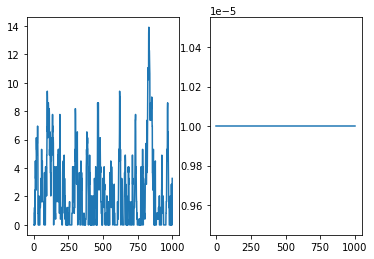

maximum steps, simulation is done ... 
elapsed_time: 50.580
Episode: 251 Exploration P: 0.0172 Total reward: -361.0232290488477 SOC: 0.4574 Cumulative_SOC_deviation: 89.7507 Fuel Consumption: 2.0204

maximum steps, simulation is done ... 
elapsed_time: 50.829
Episode: 252 Exploration P: 0.0170 Total reward: -226.57135019996286 SOC: 0.4840 Cumulative_SOC_deviation: 56.1197 Fuel Consumption: 2.0926

maximum steps, simulation is done ... 
elapsed_time: 50.995
Episode: 253 Exploration P: 0.0169 Total reward: -95.49097020975992 SOC: 0.5428 Cumulative_SOC_deviation: 23.2954 Fuel Consumption: 2.3093

maximum steps, simulation is done ... 
elapsed_time: 51.037
Episode: 254 Exploration P: 0.0168 Total reward: -127.6226853982057 SOC: 0.5377 Cumulative_SOC_deviation: 30.8228 Fuel Consumption: 4.3317

maximum steps, simulation is done ... 
elapsed_time: 50.947
Episode: 255 Exploration P: 0.0166 Total reward: -245.57487103535814 SOC: 0.4476 Cumulative_SOC_deviation: 60.5404 Fuel Consumption: 3.4134

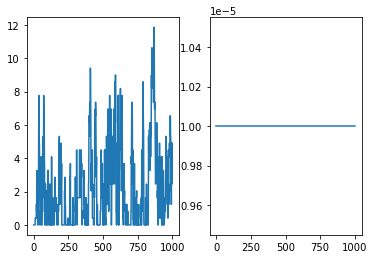

maximum steps, simulation is done ... 
elapsed_time: 51.188
Episode: 261 Exploration P: 0.0159 Total reward: -514.0938791572299 SOC: 0.3807 Cumulative_SOC_deviation: 128.1241 Fuel Consumption: 1.5974

maximum steps, simulation is done ... 
elapsed_time: 51.108
Episode: 262 Exploration P: 0.0158 Total reward: -386.4106977060907 SOC: 0.4132 Cumulative_SOC_deviation: 95.4862 Fuel Consumption: 4.4658

maximum steps, simulation is done ... 
elapsed_time: 51.191
Episode: 263 Exploration P: 0.0157 Total reward: -143.85152209845015 SOC: 0.4887 Cumulative_SOC_deviation: 35.5790 Fuel Consumption: 1.5355

maximum steps, simulation is done ... 
elapsed_time: 51.307
Episode: 264 Exploration P: 0.0155 Total reward: -250.79930503399694 SOC: 0.4929 Cumulative_SOC_deviation: 62.0090 Fuel Consumption: 2.7633

maximum steps, simulation is done ... 
elapsed_time: 51.553
Episode: 265 Exploration P: 0.0154 Total reward: -405.78126175961586 SOC: 0.3268 Cumulative_SOC_deviation: 100.1793 Fuel Consumption: 5.0

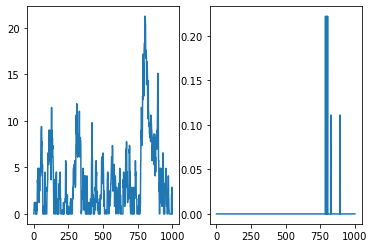

maximum steps, simulation is done ... 
elapsed_time: 50.975
Episode: 271 Exploration P: 0.0148 Total reward: -284.163730143713 SOC: 0.4653 Cumulative_SOC_deviation: 70.5771 Fuel Consumption: 1.8553

maximum steps, simulation is done ... 
elapsed_time: 51.398
Episode: 272 Exploration P: 0.0147 Total reward: -186.64298244069997 SOC: 0.5336 Cumulative_SOC_deviation: 46.0396 Fuel Consumption: 2.4847

maximum steps, simulation is done ... 
elapsed_time: 51.162
Episode: 273 Exploration P: 0.0146 Total reward: -149.91441240147898 SOC: 0.5217 Cumulative_SOC_deviation: 37.1670 Fuel Consumption: 1.2465

maximum steps, simulation is done ... 
elapsed_time: 51.539
Episode: 274 Exploration P: 0.0145 Total reward: -158.02559180804855 SOC: 0.5273 Cumulative_SOC_deviation: 39.0168 Fuel Consumption: 1.9585

maximum steps, simulation is done ... 
elapsed_time: 51.130
Episode: 275 Exploration P: 0.0144 Total reward: -541.5929546778201 SOC: 0.3298 Cumulative_SOC_deviation: 133.6653 Fuel Consumption: 6.931

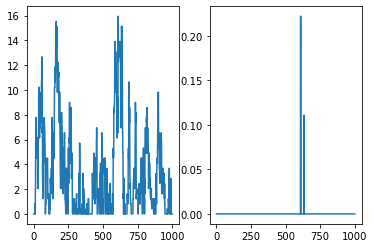

maximum steps, simulation is done ... 
elapsed_time: 51.135
Episode: 281 Exploration P: 0.0139 Total reward: -150.60272908649517 SOC: 0.4535 Cumulative_SOC_deviation: 37.1482 Fuel Consumption: 2.0101

maximum steps, simulation is done ... 
elapsed_time: 51.060
Episode: 282 Exploration P: 0.0139 Total reward: -375.5156861332448 SOC: 0.4342 Cumulative_SOC_deviation: 92.9147 Fuel Consumption: 3.8570

maximum steps, simulation is done ... 
elapsed_time: 51.394
Episode: 283 Exploration P: 0.0138 Total reward: -347.98824616737033 SOC: 0.4240 Cumulative_SOC_deviation: 86.0896 Fuel Consumption: 3.6300

maximum steps, simulation is done ... 
elapsed_time: 51.278
Episode: 284 Exploration P: 0.0137 Total reward: -720.2881947314412 SOC: 0.1410 Cumulative_SOC_deviation: 177.3176 Fuel Consumption: 11.0178

maximum steps, simulation is done ... 
elapsed_time: 51.488
Episode: 285 Exploration P: 0.0136 Total reward: -301.05244747677796 SOC: 0.4954 Cumulative_SOC_deviation: 74.1828 Fuel Consumption: 4.3

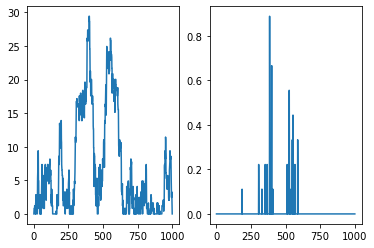

maximum steps, simulation is done ... 
elapsed_time: 51.034
Episode: 291 Exploration P: 0.0132 Total reward: -440.05808102741696 SOC: 0.3857 Cumulative_SOC_deviation: 109.1612 Fuel Consumption: 3.4134

maximum steps, simulation is done ... 
elapsed_time: 51.477
Episode: 292 Exploration P: 0.0132 Total reward: -141.59294720564472 SOC: 0.5220 Cumulative_SOC_deviation: 35.0789 Fuel Consumption: 1.2775

maximum steps, simulation is done ... 
elapsed_time: 51.577
Episode: 293 Exploration P: 0.0131 Total reward: -150.95315753505523 SOC: 0.5345 Cumulative_SOC_deviation: 37.2745 Fuel Consumption: 1.8553

maximum steps, simulation is done ... 
elapsed_time: 51.627
Episode: 294 Exploration P: 0.0130 Total reward: -309.9658185129362 SOC: 0.4649 Cumulative_SOC_deviation: 77.0276 Fuel Consumption: 1.8553

maximum steps, simulation is done ... 
elapsed_time: 51.287
Episode: 295 Exploration P: 0.0130 Total reward: -198.02818042742774 SOC: 0.4401 Cumulative_SOC_deviation: 48.8291 Fuel Consumption: 2.7

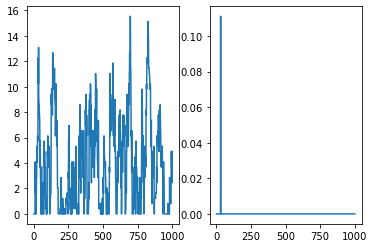

maximum steps, simulation is done ... 
elapsed_time: 51.187
Episode: 301 Exploration P: 0.0126 Total reward: -510.29663340459496 SOC: 0.3951 Cumulative_SOC_deviation: 126.9117 Fuel Consumption: 2.6498

maximum steps, simulation is done ... 
elapsed_time: 51.672
Episode: 302 Exploration P: 0.0126 Total reward: -142.40247747414088 SOC: 0.5293 Cumulative_SOC_deviation: 34.6776 Fuel Consumption: 3.6919

maximum steps, simulation is done ... 
elapsed_time: 51.600
Episode: 303 Exploration P: 0.0125 Total reward: -57.765294294903455 SOC: 0.5629 Cumulative_SOC_deviation: 13.8588 Fuel Consumption: 2.3299

maximum steps, simulation is done ... 
elapsed_time: 51.283
Episode: 304 Exploration P: 0.0125 Total reward: -418.54111155250246 SOC: 0.3304 Cumulative_SOC_deviation: 103.8181 Fuel Consumption: 3.2689

maximum steps, simulation is done ... 
elapsed_time: 51.342
Episode: 305 Exploration P: 0.0124 Total reward: -287.07101998196316 SOC: 0.4742 Cumulative_SOC_deviation: 70.9737 Fuel Consumption: 3

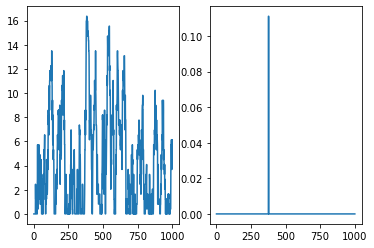

maximum steps, simulation is done ... 
elapsed_time: 50.998
Episode: 311 Exploration P: 0.0122 Total reward: -504.6519911758392 SOC: 0.4207 Cumulative_SOC_deviation: 125.2942 Fuel Consumption: 3.4753

maximum steps, simulation is done ... 
elapsed_time: 51.181
Episode: 312 Exploration P: 0.0121 Total reward: -293.63790886857845 SOC: 0.3779 Cumulative_SOC_deviation: 72.5432 Fuel Consumption: 3.4649

maximum steps, simulation is done ... 
elapsed_time: 51.112
Episode: 313 Exploration P: 0.0121 Total reward: -524.9394787569237 SOC: 0.3058 Cumulative_SOC_deviation: 130.2397 Fuel Consumption: 3.9808

maximum steps, simulation is done ... 
elapsed_time: 51.333
Episode: 314 Exploration P: 0.0120 Total reward: -194.46021376823717 SOC: 0.5103 Cumulative_SOC_deviation: 48.2492 Fuel Consumption: 1.4632

maximum steps, simulation is done ... 
elapsed_time: 51.289
Episode: 315 Exploration P: 0.0120 Total reward: -252.8910441667102 SOC: 0.3809 Cumulative_SOC_deviation: 62.3127 Fuel Consumption: 3.64

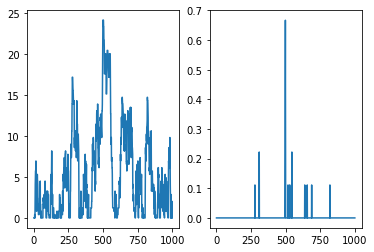

maximum steps, simulation is done ... 
elapsed_time: 51.476
Episode: 321 Exploration P: 0.0118 Total reward: -312.6937300990371 SOC: 0.4420 Cumulative_SOC_deviation: 77.8076 Fuel Consumption: 1.4632

maximum steps, simulation is done ... 
elapsed_time: 51.432
Episode: 322 Exploration P: 0.0117 Total reward: -203.08849153276068 SOC: 0.4769 Cumulative_SOC_deviation: 50.0194 Fuel Consumption: 3.0109

maximum steps, simulation is done ... 
elapsed_time: 51.188
Episode: 323 Exploration P: 0.0117 Total reward: -562.4784779348853 SOC: 0.3805 Cumulative_SOC_deviation: 139.6708 Fuel Consumption: 3.7951

maximum steps, simulation is done ... 
elapsed_time: 51.346
Episode: 324 Exploration P: 0.0117 Total reward: -287.2329420102296 SOC: 0.4445 Cumulative_SOC_deviation: 71.3960 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 52.950
Episode: 325 Exploration P: 0.0116 Total reward: -112.26918757747211 SOC: 0.5314 Cumulative_SOC_deviation: 27.6164 Fuel Consumption: 1.803

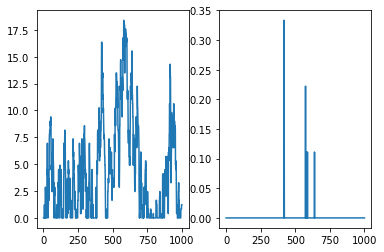

maximum steps, simulation is done ... 
elapsed_time: 52.190
Episode: 331 Exploration P: 0.0114 Total reward: -213.66949001252394 SOC: 0.4887 Cumulative_SOC_deviation: 53.0748 Fuel Consumption: 1.3704

maximum steps, simulation is done ... 
elapsed_time: 51.450
Episode: 332 Exploration P: 0.0114 Total reward: -152.13769896364755 SOC: 0.5079 Cumulative_SOC_deviation: 37.7718 Fuel Consumption: 1.0505

maximum steps, simulation is done ... 
elapsed_time: 51.220
Episode: 333 Exploration P: 0.0114 Total reward: -129.210136713455 SOC: 0.5353 Cumulative_SOC_deviation: 31.8697 Fuel Consumption: 1.7315

maximum steps, simulation is done ... 
elapsed_time: 51.636
Episode: 334 Exploration P: 0.0114 Total reward: -203.5400154526892 SOC: 0.5090 Cumulative_SOC_deviation: 50.4238 Fuel Consumption: 1.8450

maximum steps, simulation is done ... 
elapsed_time: 51.114
Episode: 335 Exploration P: 0.0113 Total reward: -792.7548091748861 SOC: 0.3404 Cumulative_SOC_deviation: 197.1703 Fuel Consumption: 4.0737

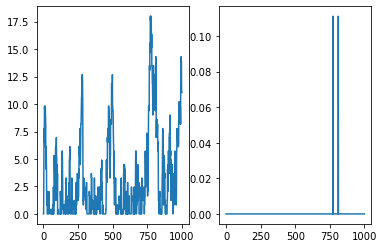

maximum steps, simulation is done ... 
elapsed_time: 51.280
Episode: 341 Exploration P: 0.0112 Total reward: -187.92843648193997 SOC: 0.4920 Cumulative_SOC_deviation: 46.3712 Fuel Consumption: 2.4434

maximum steps, simulation is done ... 
elapsed_time: 51.194
Episode: 342 Exploration P: 0.0112 Total reward: -161.42508434539243 SOC: 0.5174 Cumulative_SOC_deviation: 39.7274 Fuel Consumption: 2.5157

maximum steps, simulation is done ... 
elapsed_time: 51.743
Episode: 343 Exploration P: 0.0111 Total reward: -228.6387416986797 SOC: 0.4744 Cumulative_SOC_deviation: 56.6365 Fuel Consumption: 2.0926

maximum steps, simulation is done ... 
elapsed_time: 51.346
Episode: 344 Exploration P: 0.0111 Total reward: -842.8744904662207 SOC: 0.1668 Cumulative_SOC_deviation: 208.1860 Fuel Consumption: 10.1305

maximum steps, simulation is done ... 
elapsed_time: 51.453
Episode: 345 Exploration P: 0.0111 Total reward: -174.00868596080818 SOC: 0.5098 Cumulative_SOC_deviation: 43.1157 Fuel Consumption: 1.5

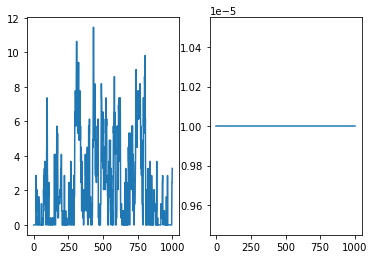

maximum steps, simulation is done ... 
elapsed_time: 51.149
Episode: 351 Exploration P: 0.0110 Total reward: -185.7171229642975 SOC: 0.5226 Cumulative_SOC_deviation: 46.2337 Fuel Consumption: 0.7822

maximum steps, simulation is done ... 
elapsed_time: 51.026
Episode: 352 Exploration P: 0.0110 Total reward: -223.2869528300866 SOC: 0.4984 Cumulative_SOC_deviation: 55.4405 Fuel Consumption: 1.5251

maximum steps, simulation is done ... 
elapsed_time: 51.504
Episode: 353 Exploration P: 0.0109 Total reward: -295.99266354165405 SOC: 0.4732 Cumulative_SOC_deviation: 73.6195 Fuel Consumption: 1.5148

maximum steps, simulation is done ... 
elapsed_time: 51.502
Episode: 354 Exploration P: 0.0109 Total reward: -766.359256957361 SOC: 0.3069 Cumulative_SOC_deviation: 189.9471 Fuel Consumption: 6.5707

maximum steps, simulation is done ... 
elapsed_time: 51.659
Episode: 355 Exploration P: 0.0109 Total reward: -97.06936130706951 SOC: 0.5477 Cumulative_SOC_deviation: 23.8809 Fuel Consumption: 1.5458


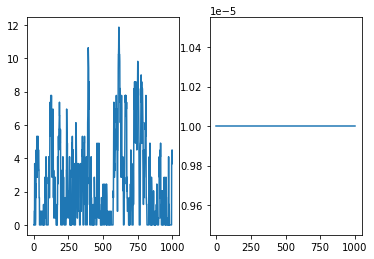

maximum steps, simulation is done ... 
elapsed_time: 51.144
Episode: 361 Exploration P: 0.0108 Total reward: -206.95470379569932 SOC: 0.4453 Cumulative_SOC_deviation: 51.3264 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 51.065
Episode: 362 Exploration P: 0.0108 Total reward: -233.69048792226084 SOC: 0.4469 Cumulative_SOC_deviation: 57.6183 Fuel Consumption: 3.2173

maximum steps, simulation is done ... 
elapsed_time: 51.684
Episode: 363 Exploration P: 0.0108 Total reward: -221.81694386411638 SOC: 0.4670 Cumulative_SOC_deviation: 55.1994 Fuel Consumption: 1.0195

maximum steps, simulation is done ... 
elapsed_time: 51.609
Episode: 364 Exploration P: 0.0107 Total reward: -851.0652028678168 SOC: 0.2367 Cumulative_SOC_deviation: 209.6946 Fuel Consumption: 12.2870

maximum steps, simulation is done ... 
elapsed_time: 51.039
Episode: 365 Exploration P: 0.0107 Total reward: -145.29206102080323 SOC: 0.5064 Cumulative_SOC_deviation: 36.0269 Fuel Consumption: 1.

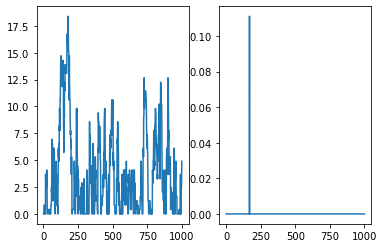

maximum steps, simulation is done ... 
elapsed_time: 51.237
Episode: 371 Exploration P: 0.0107 Total reward: -301.6831209914366 SOC: 0.4733 Cumulative_SOC_deviation: 74.8357 Fuel Consumption: 2.3403

maximum steps, simulation is done ... 
elapsed_time: 51.323
Episode: 372 Exploration P: 0.0106 Total reward: -646.3929931261183 SOC: 0.2537 Cumulative_SOC_deviation: 159.9943 Fuel Consumption: 6.4159

maximum steps, simulation is done ... 
elapsed_time: 51.459
Episode: 373 Exploration P: 0.0106 Total reward: -353.8522600144264 SOC: 0.4505 Cumulative_SOC_deviation: 88.0018 Fuel Consumption: 1.8450

maximum steps, simulation is done ... 
elapsed_time: 51.284
Episode: 374 Exploration P: 0.0106 Total reward: -169.87257735079305 SOC: 0.5209 Cumulative_SOC_deviation: 41.8882 Fuel Consumption: 2.3196

maximum steps, simulation is done ... 
elapsed_time: 51.373
Episode: 375 Exploration P: 0.0106 Total reward: -231.62167598404335 SOC: 0.4803 Cumulative_SOC_deviation: 57.4339 Fuel Consumption: 1.886

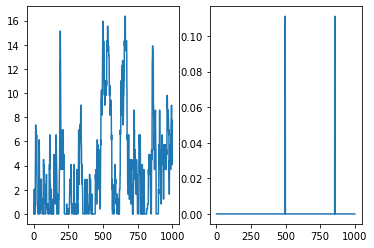

maximum steps, simulation is done ... 
elapsed_time: 51.583
Episode: 381 Exploration P: 0.0105 Total reward: -101.21712232957145 SOC: 0.5231 Cumulative_SOC_deviation: 24.7863 Fuel Consumption: 2.0720

maximum steps, simulation is done ... 
elapsed_time: 51.266
Episode: 382 Exploration P: 0.0105 Total reward: -158.22004406933328 SOC: 0.5122 Cumulative_SOC_deviation: 39.3285 Fuel Consumption: 0.9060

maximum steps, simulation is done ... 
elapsed_time: 51.259
Episode: 383 Exploration P: 0.0105 Total reward: -135.91457893212188 SOC: 0.4998 Cumulative_SOC_deviation: 33.5741 Fuel Consumption: 1.6180

battery power is 109885.16850324225(+) but condition is not avail
elapsed_time: 29.331
Episode: 384 Exploration P: 0.0105 Total reward: -1064.534213504016 SOC: 0.3768 Cumulative_SOC_deviation: 15.2825 Fuel Consumption: 4.2971

maximum steps, simulation is done ... 
elapsed_time: 51.663
Episode: 385 Exploration P: 0.0105 Total reward: -365.3709146773547 SOC: 0.4141 Cumulative_SOC_deviation: 91.0

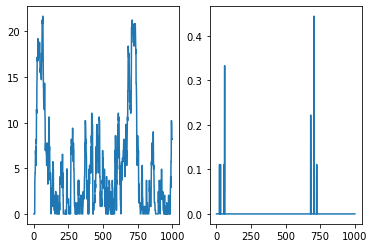

maximum steps, simulation is done ... 
elapsed_time: 51.262
Episode: 391 Exploration P: 0.0104 Total reward: -236.89283185051258 SOC: 0.4431 Cumulative_SOC_deviation: 58.7129 Fuel Consumption: 2.0410

maximum steps, simulation is done ... 
elapsed_time: 51.510
Episode: 392 Exploration P: 0.0104 Total reward: -346.2901991040662 SOC: 0.4340 Cumulative_SOC_deviation: 86.2274 Fuel Consumption: 1.3807

maximum steps, simulation is done ... 
elapsed_time: 51.208
Episode: 393 Exploration P: 0.0104 Total reward: -783.8725594826547 SOC: 0.0585 Cumulative_SOC_deviation: 190.6728 Fuel Consumption: 21.1812

maximum steps, simulation is done ... 
elapsed_time: 51.093
Episode: 394 Exploration P: 0.0104 Total reward: -515.3257304653774 SOC: 0.2993 Cumulative_SOC_deviation: 127.8904 Fuel Consumption: 3.7642

maximum steps, simulation is done ... 
elapsed_time: 51.643
Episode: 395 Exploration P: 0.0104 Total reward: -211.87365493203995 SOC: 0.4723 Cumulative_SOC_deviation: 52.5046 Fuel Consumption: 1.8

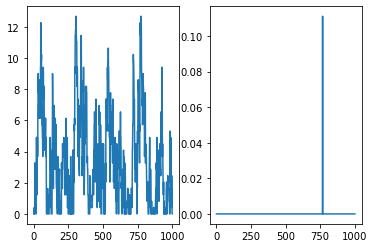

model is saved..

Trial 5

maximum steps, simulation is done ... 
elapsed_time: 6.859
Episode: 1 Exploration P: 1.0000 Total reward: -1851.0734384554391 SOC: 1.0000 Cumulative_SOC_deviation: 349.7563 Fuel Consumption: 102.2921

maximum steps, simulation is done ... 
elapsed_time: 7.916
Episode: 2 Exploration P: 1.0000 Total reward: -1888.3576104869028 SOC: 1.0000 Cumulative_SOC_deviation: 356.6394 Fuel Consumption: 105.1605

maximum steps, simulation is done ... 
elapsed_time: 7.946
Episode: 3 Exploration P: 1.0000 Total reward: -1849.3741794497957 SOC: 1.0000 Cumulative_SOC_deviation: 350.0376 Fuel Consumption: 99.1863

maximum steps, simulation is done ... 
elapsed_time: 8.667
Episode: 4 Exploration P: 1.0000 Total reward: -1866.948108020439 SOC: 1.0000 Cumulative_SOC_deviation: 353.3192 Fuel Consumption: 100.3523


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X mo

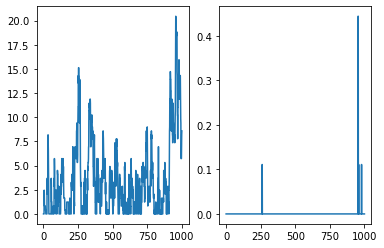

maximum steps, simulation is done ... 
elapsed_time: 49.932
Episode: 11 Exploration P: 0.8879 Total reward: -1823.4172048694102 SOC: 1.0000 Cumulative_SOC_deviation: 345.8842 Fuel Consumption: 93.9963

maximum steps, simulation is done ... 
elapsed_time: 50.250
Episode: 12 Exploration P: 0.8705 Total reward: -1823.0688892398055 SOC: 1.0000 Cumulative_SOC_deviation: 346.4336 Fuel Consumption: 90.9008

maximum steps, simulation is done ... 
elapsed_time: 50.416
Episode: 13 Exploration P: 0.8534 Total reward: -1799.9504011913418 SOC: 1.0000 Cumulative_SOC_deviation: 342.7592 Fuel Consumption: 86.1545

maximum steps, simulation is done ... 
elapsed_time: 50.412
Episode: 14 Exploration P: 0.8367 Total reward: -1782.2289016876407 SOC: 0.9987 Cumulative_SOC_deviation: 337.4794 Fuel Consumption: 94.8321

maximum steps, simulation is done ... 
elapsed_time: 50.112
Episode: 15 Exploration P: 0.8203 Total reward: -1815.6909827255176 SOC: 1.0000 Cumulative_SOC_deviation: 344.0129 Fuel Consumption:

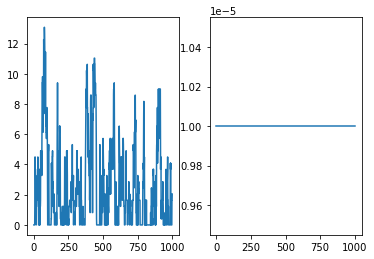

maximum steps, simulation is done ... 
elapsed_time: 50.529
Episode: 21 Exploration P: 0.7286 Total reward: -1754.7790956021936 SOC: 1.0000 Cumulative_SOC_deviation: 333.6424 Fuel Consumption: 86.5672

maximum steps, simulation is done ... 
elapsed_time: 50.607
Episode: 22 Exploration P: 0.7144 Total reward: -1738.751231039317 SOC: 0.9651 Cumulative_SOC_deviation: 332.5644 Fuel Consumption: 75.9292

maximum steps, simulation is done ... 
elapsed_time: 50.527
Episode: 23 Exploration P: 0.7004 Total reward: -1762.3794498218306 SOC: 0.9995 Cumulative_SOC_deviation: 337.1477 Fuel Consumption: 76.6412

maximum steps, simulation is done ... 
elapsed_time: 50.668
Episode: 24 Exploration P: 0.6867 Total reward: -1739.341285617741 SOC: 1.0000 Cumulative_SOC_deviation: 333.5842 Fuel Consumption: 71.4202

maximum steps, simulation is done ... 
elapsed_time: 50.429
Episode: 25 Exploration P: 0.6733 Total reward: -1751.433568911448 SOC: 0.9997 Cumulative_SOC_deviation: 334.6902 Fuel Consumption: 77

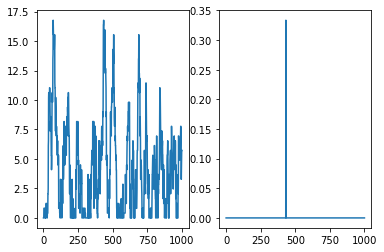

maximum steps, simulation is done ... 
elapsed_time: 50.889
Episode: 31 Exploration P: 0.5982 Total reward: -1688.2867746613297 SOC: 1.0000 Cumulative_SOC_deviation: 324.1327 Fuel Consumption: 67.6231

maximum steps, simulation is done ... 
elapsed_time: 51.040
Episode: 32 Exploration P: 0.5866 Total reward: -1666.1004278593011 SOC: 0.9999 Cumulative_SOC_deviation: 319.8440 Fuel Consumption: 66.8802

maximum steps, simulation is done ... 
elapsed_time: 50.906
Episode: 33 Exploration P: 0.5751 Total reward: -1685.073560110668 SOC: 0.9997 Cumulative_SOC_deviation: 324.0142 Fuel Consumption: 65.0023

maximum steps, simulation is done ... 
elapsed_time: 50.682
Episode: 34 Exploration P: 0.5639 Total reward: -1631.903096698671 SOC: 1.0000 Cumulative_SOC_deviation: 313.7599 Fuel Consumption: 63.1038

maximum steps, simulation is done ... 
elapsed_time: 50.711
Episode: 35 Exploration P: 0.5530 Total reward: -1622.9799932704323 SOC: 1.0000 Cumulative_SOC_deviation: 311.1477 Fuel Consumption: 6

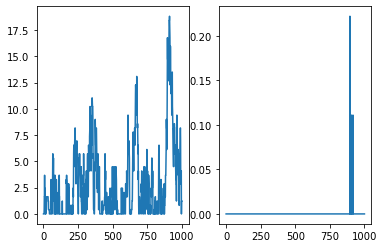

maximum steps, simulation is done ... 
elapsed_time: 50.843
Episode: 41 Exploration P: 0.4915 Total reward: -1537.3512781479942 SOC: 0.9973 Cumulative_SOC_deviation: 295.4005 Fuel Consumption: 60.3488

maximum steps, simulation is done ... 
elapsed_time: 51.064
Episode: 42 Exploration P: 0.4820 Total reward: -1566.43385742149 SOC: 1.0000 Cumulative_SOC_deviation: 302.3066 Fuel Consumption: 54.9009

maximum steps, simulation is done ... 
elapsed_time: 50.840
Episode: 43 Exploration P: 0.4726 Total reward: -1516.1335265885969 SOC: 0.9382 Cumulative_SOC_deviation: 292.5127 Fuel Consumption: 53.5698

maximum steps, simulation is done ... 
elapsed_time: 50.860
Episode: 44 Exploration P: 0.4634 Total reward: -1496.267191187144 SOC: 1.0000 Cumulative_SOC_deviation: 288.2258 Fuel Consumption: 55.1382

maximum steps, simulation is done ... 
elapsed_time: 50.936
Episode: 45 Exploration P: 0.4544 Total reward: -1580.722237782634 SOC: 0.9891 Cumulative_SOC_deviation: 304.8073 Fuel Consumption: 56.

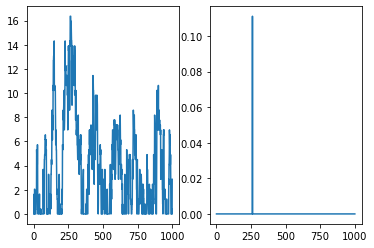

maximum steps, simulation is done ... 
elapsed_time: 50.438
Episode: 51 Exploration P: 0.4041 Total reward: -1101.582829813668 SOC: 0.9970 Cumulative_SOC_deviation: 209.4437 Fuel Consumption: 54.3643

maximum steps, simulation is done ... 
elapsed_time: 51.194
Episode: 52 Exploration P: 0.3963 Total reward: -1410.4754297255977 SOC: 1.0000 Cumulative_SOC_deviation: 272.9495 Fuel Consumption: 45.7280

maximum steps, simulation is done ... 
elapsed_time: 50.998
Episode: 53 Exploration P: 0.3887 Total reward: -1020.633613433521 SOC: 1.0000 Cumulative_SOC_deviation: 192.7091 Fuel Consumption: 57.0883

maximum steps, simulation is done ... 
elapsed_time: 51.386
Episode: 54 Exploration P: 0.3812 Total reward: -1412.8021676249277 SOC: 1.0000 Cumulative_SOC_deviation: 273.5180 Fuel Consumption: 45.2121

maximum steps, simulation is done ... 
elapsed_time: 51.102
Episode: 55 Exploration P: 0.3738 Total reward: -1178.2659561237765 SOC: 0.9454 Cumulative_SOC_deviation: 224.4687 Fuel Consumption: 5

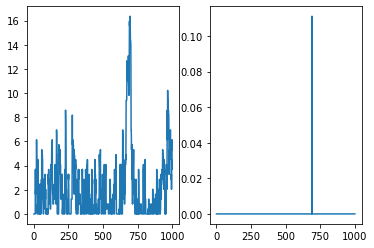

maximum steps, simulation is done ... 
elapsed_time: 50.603
Episode: 61 Exploration P: 0.3326 Total reward: -1102.6347004724084 SOC: 0.9903 Cumulative_SOC_deviation: 212.4874 Fuel Consumption: 40.1975

maximum steps, simulation is done ... 
elapsed_time: 51.134
Episode: 62 Exploration P: 0.3262 Total reward: -1306.9700017045086 SOC: 1.0000 Cumulative_SOC_deviation: 253.1337 Fuel Consumption: 41.3016

maximum steps, simulation is done ... 
elapsed_time: 51.020
Episode: 63 Exploration P: 0.3200 Total reward: -1288.840753532046 SOC: 1.0000 Cumulative_SOC_deviation: 249.5883 Fuel Consumption: 40.8991

maximum steps, simulation is done ... 
elapsed_time: 51.304
Episode: 64 Exploration P: 0.3138 Total reward: -1105.7598284811913 SOC: 0.9990 Cumulative_SOC_deviation: 213.3106 Fuel Consumption: 39.2070

maximum steps, simulation is done ... 
elapsed_time: 50.994
Episode: 65 Exploration P: 0.3078 Total reward: -1199.6630388082779 SOC: 0.9847 Cumulative_SOC_deviation: 230.5497 Fuel Consumption: 

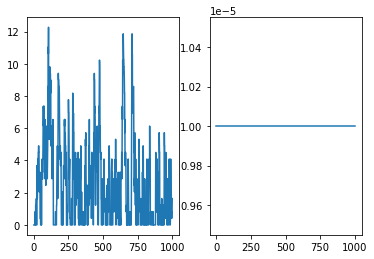

maximum steps, simulation is done ... 
elapsed_time: 50.297
Episode: 71 Exploration P: 0.2741 Total reward: -973.6687940327411 SOC: 0.9841 Cumulative_SOC_deviation: 186.4549 Fuel Consumption: 41.3944

maximum steps, simulation is done ... 
elapsed_time: 50.988
Episode: 72 Exploration P: 0.2689 Total reward: -967.340932635972 SOC: 0.9615 Cumulative_SOC_deviation: 186.5637 Fuel Consumption: 34.5225

maximum steps, simulation is done ... 
elapsed_time: 51.388
Episode: 73 Exploration P: 0.2637 Total reward: -863.3898451026314 SOC: 0.8694 Cumulative_SOC_deviation: 165.6806 Fuel Consumption: 34.9869

maximum steps, simulation is done ... 
elapsed_time: 51.173
Episode: 74 Exploration P: 0.2587 Total reward: -789.6515767990488 SOC: 0.9284 Cumulative_SOC_deviation: 149.8619 Fuel Consumption: 40.3420

maximum steps, simulation is done ... 
elapsed_time: 51.355
Episode: 75 Exploration P: 0.2538 Total reward: -733.9832004405357 SOC: 0.8264 Cumulative_SOC_deviation: 138.5652 Fuel Consumption: 41.15

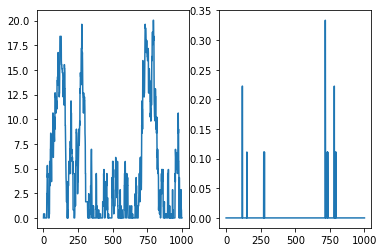

maximum steps, simulation is done ... 
elapsed_time: 50.404
Episode: 81 Exploration P: 0.2262 Total reward: -756.6246264354296 SOC: 0.8779 Cumulative_SOC_deviation: 144.4452 Fuel Consumption: 34.3987

maximum steps, simulation is done ... 
elapsed_time: 51.519
Episode: 82 Exploration P: 0.2219 Total reward: -613.4989206581823 SOC: 0.8290 Cumulative_SOC_deviation: 116.5939 Fuel Consumption: 30.5294

maximum steps, simulation is done ... 
elapsed_time: 51.601
Episode: 83 Exploration P: 0.2177 Total reward: -685.8003795494617 SOC: 0.8783 Cumulative_SOC_deviation: 131.3307 Fuel Consumption: 29.1468

maximum steps, simulation is done ... 
elapsed_time: 51.616
Episode: 84 Exploration P: 0.2136 Total reward: -793.7177686722027 SOC: 0.8788 Cumulative_SOC_deviation: 152.3591 Fuel Consumption: 31.9224

maximum steps, simulation is done ... 
elapsed_time: 51.358
Episode: 85 Exploration P: 0.2095 Total reward: -351.87737161944125 SOC: 0.6498 Cumulative_SOC_deviation: 62.3607 Fuel Consumption: 40.0

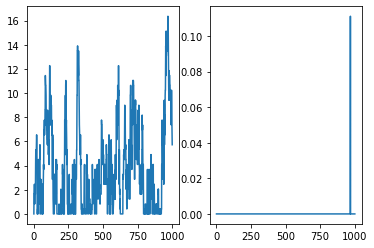

maximum steps, simulation is done ... 
elapsed_time: 50.560
Episode: 91 Exploration P: 0.1870 Total reward: -290.90066159925925 SOC: 0.6946 Cumulative_SOC_deviation: 53.0483 Fuel Consumption: 25.6593

maximum steps, simulation is done ... 
elapsed_time: 51.061
Episode: 92 Exploration P: 0.1834 Total reward: -562.4464539729928 SOC: 0.8225 Cumulative_SOC_deviation: 106.8911 Fuel Consumption: 27.9912

maximum steps, simulation is done ... 
elapsed_time: 51.557
Episode: 93 Exploration P: 0.1800 Total reward: -524.7446762464142 SOC: 0.8133 Cumulative_SOC_deviation: 99.8295 Fuel Consumption: 25.5973

maximum steps, simulation is done ... 
elapsed_time: 51.258
Episode: 94 Exploration P: 0.1766 Total reward: -639.0252709258984 SOC: 0.8184 Cumulative_SOC_deviation: 122.8259 Fuel Consumption: 24.8957

maximum steps, simulation is done ... 
elapsed_time: 51.476
Episode: 95 Exploration P: 0.1733 Total reward: -552.977322578147 SOC: 0.8170 Cumulative_SOC_deviation: 105.5069 Fuel Consumption: 25.442

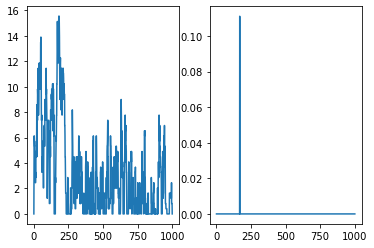

maximum steps, simulation is done ... 
elapsed_time: 51.796
Episode: 101 Exploration P: 0.1549 Total reward: -640.6246327912596 SOC: 0.8206 Cumulative_SOC_deviation: 123.2428 Fuel Consumption: 24.4108

maximum steps, simulation is done ... 
elapsed_time: 50.747
Episode: 102 Exploration P: 0.1520 Total reward: -398.4414800406391 SOC: 0.7254 Cumulative_SOC_deviation: 74.6679 Fuel Consumption: 25.1021

maximum steps, simulation is done ... 
elapsed_time: 51.608
Episode: 103 Exploration P: 0.1492 Total reward: -348.190874032675 SOC: 0.6968 Cumulative_SOC_deviation: 65.7259 Fuel Consumption: 19.5612

maximum steps, simulation is done ... 
elapsed_time: 51.353
Episode: 104 Exploration P: 0.1464 Total reward: -293.7050414540567 SOC: 0.7519 Cumulative_SOC_deviation: 54.9010 Fuel Consumption: 19.2001

maximum steps, simulation is done ... 
elapsed_time: 51.685
Episode: 105 Exploration P: 0.1437 Total reward: -254.67356927039282 SOC: 0.5976 Cumulative_SOC_deviation: 46.4859 Fuel Consumption: 22.

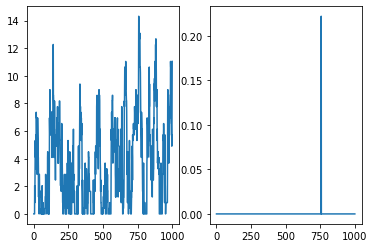

maximum steps, simulation is done ... 
elapsed_time: 51.560
Episode: 111 Exploration P: 0.1286 Total reward: -161.44208475373787 SOC: 0.6907 Cumulative_SOC_deviation: 28.3411 Fuel Consumption: 19.7366

maximum steps, simulation is done ... 
elapsed_time: 50.575
Episode: 112 Exploration P: 0.1262 Total reward: -180.0288627009605 SOC: 0.6509 Cumulative_SOC_deviation: 31.9945 Fuel Consumption: 20.0565

maximum steps, simulation is done ... 
elapsed_time: 51.542
Episode: 113 Exploration P: 0.1239 Total reward: -297.4628183674705 SOC: 0.7145 Cumulative_SOC_deviation: 55.9972 Fuel Consumption: 17.4770

maximum steps, simulation is done ... 
elapsed_time: 51.611
Episode: 114 Exploration P: 0.1217 Total reward: -117.7032886099264 SOC: 0.6515 Cumulative_SOC_deviation: 19.1517 Fuel Consumption: 21.9447

maximum steps, simulation is done ... 
elapsed_time: 51.796
Episode: 115 Exploration P: 0.1194 Total reward: -174.17509846884317 SOC: 0.6586 Cumulative_SOC_deviation: 31.0879 Fuel Consumption: 18

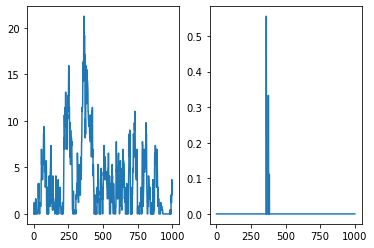

maximum steps, simulation is done ... 
elapsed_time: 51.934
Episode: 121 Exploration P: 0.1071 Total reward: -169.4957145277852 SOC: 0.5411 Cumulative_SOC_deviation: 31.1343 Fuel Consumption: 13.8244

maximum steps, simulation is done ... 
elapsed_time: 50.787
Episode: 122 Exploration P: 0.1051 Total reward: -259.3040978719274 SOC: 0.6949 Cumulative_SOC_deviation: 49.0980 Fuel Consumption: 13.8140

maximum steps, simulation is done ... 
elapsed_time: 51.969
Episode: 123 Exploration P: 0.1032 Total reward: -192.8296945452381 SOC: 0.6761 Cumulative_SOC_deviation: 35.4482 Fuel Consumption: 15.5888

maximum steps, simulation is done ... 
elapsed_time: 51.684
Episode: 124 Exploration P: 0.1014 Total reward: -245.49339338641718 SOC: 0.7094 Cumulative_SOC_deviation: 46.1047 Fuel Consumption: 14.9697

maximum steps, simulation is done ... 
elapsed_time: 51.919
Episode: 125 Exploration P: 0.0996 Total reward: -189.9047140075489 SOC: 0.5514 Cumulative_SOC_deviation: 34.3782 Fuel Consumption: 18.

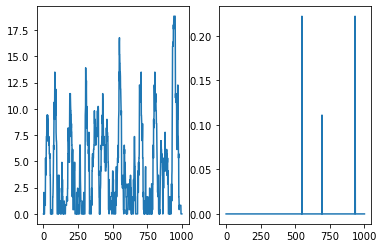

maximum steps, simulation is done ... 
elapsed_time: 51.617
Episode: 131 Exploration P: 0.0894 Total reward: -84.77929653271597 SOC: 0.6302 Cumulative_SOC_deviation: 13.9846 Fuel Consumption: 14.8562

maximum steps, simulation is done ... 
elapsed_time: 51.094
Episode: 132 Exploration P: 0.0879 Total reward: -118.73236401032733 SOC: 0.5791 Cumulative_SOC_deviation: 21.3964 Fuel Consumption: 11.7504

maximum steps, simulation is done ... 
elapsed_time: 51.509
Episode: 133 Exploration P: 0.0863 Total reward: -50.705390125158694 SOC: 0.5918 Cumulative_SOC_deviation: 8.0985 Fuel Consumption: 10.2130

maximum steps, simulation is done ... 
elapsed_time: 51.607
Episode: 134 Exploration P: 0.0848 Total reward: -91.36853379477394 SOC: 0.6291 Cumulative_SOC_deviation: 15.7585 Fuel Consumption: 12.5759

maximum steps, simulation is done ... 
elapsed_time: 51.633
Episode: 135 Exploration P: 0.0833 Total reward: -156.87442671914727 SOC: 0.6428 Cumulative_SOC_deviation: 28.8721 Fuel Consumption: 12

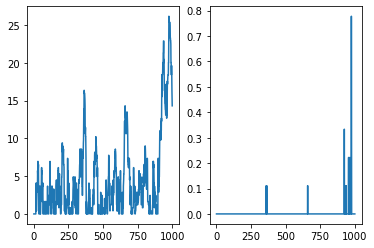

maximum steps, simulation is done ... 
elapsed_time: 51.671
Episode: 141 Exploration P: 0.0750 Total reward: -296.4370811130358 SOC: 0.4822 Cumulative_SOC_deviation: 56.7784 Fuel Consumption: 12.5449

maximum steps, simulation is done ... 
elapsed_time: 51.489
Episode: 142 Exploration P: 0.0737 Total reward: -93.08232775807204 SOC: 0.5670 Cumulative_SOC_deviation: 16.3015 Fuel Consumption: 11.5750

maximum steps, simulation is done ... 
elapsed_time: 50.837
Episode: 143 Exploration P: 0.0725 Total reward: -302.1926734969465 SOC: 0.5492 Cumulative_SOC_deviation: 56.5985 Fuel Consumption: 19.2001

maximum steps, simulation is done ... 
elapsed_time: 51.544
Episode: 144 Exploration P: 0.0712 Total reward: -96.85855009264556 SOC: 0.5853 Cumulative_SOC_deviation: 17.1743 Fuel Consumption: 10.9869

maximum steps, simulation is done ... 
elapsed_time: 51.804
Episode: 145 Exploration P: 0.0700 Total reward: -429.00652663940735 SOC: 0.4630 Cumulative_SOC_deviation: 83.4822 Fuel Consumption: 11.

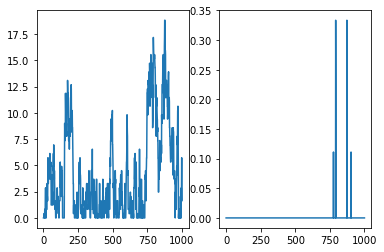

maximum steps, simulation is done ... 
elapsed_time: 51.483
Episode: 151 Exploration P: 0.0632 Total reward: -66.03764120809619 SOC: 0.5922 Cumulative_SOC_deviation: 11.4311 Fuel Consumption: 8.8820

maximum steps, simulation is done ... 
elapsed_time: 51.717
Episode: 152 Exploration P: 0.0622 Total reward: -180.10368838632715 SOC: 0.5583 Cumulative_SOC_deviation: 34.7809 Fuel Consumption: 6.1992

maximum steps, simulation is done ... 
elapsed_time: 50.955
Episode: 153 Exploration P: 0.0611 Total reward: -328.26000442706004 SOC: 0.4890 Cumulative_SOC_deviation: 63.8261 Fuel Consumption: 9.1296

battery power is 119458.80972306205(+) but condition is not avail
elapsed_time: 41.887
Episode: 154 Exploration P: 0.0603 Total reward: -1253.0381699396248 SOC: 0.1738 Cumulative_SOC_deviation: 45.6444 Fuel Consumption: 26.9475

maximum steps, simulation is done ... 
elapsed_time: 51.754
Episode: 155 Exploration P: 0.0593 Total reward: -347.39515398663934 SOC: 0.4946 Cumulative_SOC_deviation: 67

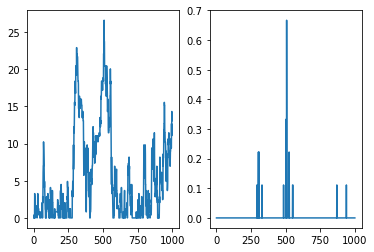

maximum steps, simulation is done ... 
elapsed_time: 50.958
Episode: 161 Exploration P: 0.0537 Total reward: -81.64858303219421 SOC: 0.5897 Cumulative_SOC_deviation: 14.6544 Fuel Consumption: 8.3764

maximum steps, simulation is done ... 
elapsed_time: 51.725
Episode: 162 Exploration P: 0.0529 Total reward: -150.46197196736316 SOC: 0.4888 Cumulative_SOC_deviation: 28.4790 Fuel Consumption: 8.0668

maximum steps, simulation is done ... 
elapsed_time: 50.928
Episode: 163 Exploration P: 0.0520 Total reward: -128.96595912492955 SOC: 0.5762 Cumulative_SOC_deviation: 24.0890 Fuel Consumption: 8.5208

maximum steps, simulation is done ... 
elapsed_time: 52.061
Episode: 164 Exploration P: 0.0512 Total reward: -68.61626037382857 SOC: 0.6117 Cumulative_SOC_deviation: 11.8272 Fuel Consumption: 9.4804

maximum steps, simulation is done ... 
elapsed_time: 51.742
Episode: 165 Exploration P: 0.0504 Total reward: -263.4046202439282 SOC: 0.5382 Cumulative_SOC_deviation: 50.5682 Fuel Consumption: 10.563

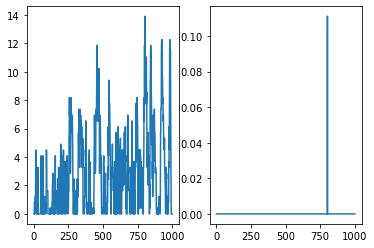

maximum steps, simulation is done ... 
elapsed_time: 55.737
Episode: 171 Exploration P: 0.0458 Total reward: -303.750045439051 SOC: 0.4762 Cumulative_SOC_deviation: 59.5741 Fuel Consumption: 5.8794

maximum steps, simulation is done ... 
elapsed_time: 54.080
Episode: 172 Exploration P: 0.0451 Total reward: -325.75676854686 SOC: 0.4796 Cumulative_SOC_deviation: 63.6701 Fuel Consumption: 7.4065

maximum steps, simulation is done ... 
elapsed_time: 55.364
Episode: 173 Exploration P: 0.0444 Total reward: -478.5082030805101 SOC: 0.4519 Cumulative_SOC_deviation: 94.2307 Fuel Consumption: 7.3549

maximum steps, simulation is done ... 
elapsed_time: 51.239
Episode: 174 Exploration P: 0.0437 Total reward: -69.06125576105688 SOC: 0.5614 Cumulative_SOC_deviation: 12.6054 Fuel Consumption: 6.0342

maximum steps, simulation is done ... 
elapsed_time: 51.986
Episode: 175 Exploration P: 0.0430 Total reward: -127.54906892646758 SOC: 0.5421 Cumulative_SOC_deviation: 24.2101 Fuel Consumption: 6.4985

ma

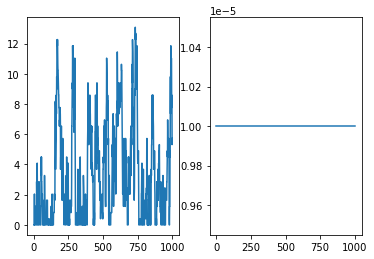

maximum steps, simulation is done ... 
elapsed_time: 50.820
Episode: 181 Exploration P: 0.0393 Total reward: -118.11379530203254 SOC: 0.5737 Cumulative_SOC_deviation: 22.5707 Fuel Consumption: 5.2603

maximum steps, simulation is done ... 
elapsed_time: 51.710
Episode: 182 Exploration P: 0.0387 Total reward: -113.64764797773385 SOC: 0.5636 Cumulative_SOC_deviation: 21.5475 Fuel Consumption: 5.9103

maximum steps, simulation is done ... 
elapsed_time: 51.566
Episode: 183 Exploration P: 0.0382 Total reward: -107.18117097357175 SOC: 0.5547 Cumulative_SOC_deviation: 20.4956 Fuel Consumption: 4.7031

maximum steps, simulation is done ... 
elapsed_time: 51.113
Episode: 184 Exploration P: 0.0376 Total reward: -294.7492330393206 SOC: 0.5089 Cumulative_SOC_deviation: 57.9184 Fuel Consumption: 5.1571

battery power is 104304.07798390067(+) but condition is not avail
elapsed_time: 15.161
Episode: 185 Exploration P: 0.0374 Total reward: -1054.0143290970605 SOC: 0.4440 Cumulative_SOC_deviation: 10.

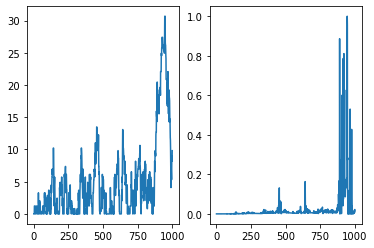

maximum steps, simulation is done ... 
elapsed_time: 51.904
Episode: 191 Exploration P: 0.0343 Total reward: -43.54260845229977 SOC: 0.6058 Cumulative_SOC_deviation: 6.6545 Fuel Consumption: 10.2703

maximum steps, simulation is done ... 
elapsed_time: 51.289
Episode: 192 Exploration P: 0.0339 Total reward: -122.64442180061712 SOC: 0.5907 Cumulative_SOC_deviation: 16.5074 Fuel Consumption: 40.1073

maximum steps, simulation is done ... 
elapsed_time: 51.724
Episode: 193 Exploration P: 0.0334 Total reward: -66.30020470789496 SOC: 0.5793 Cumulative_SOC_deviation: 11.7838 Fuel Consumption: 7.3813

maximum steps, simulation is done ... 
elapsed_time: 52.027
Episode: 194 Exploration P: 0.0329 Total reward: -104.04917677760339 SOC: 0.5963 Cumulative_SOC_deviation: 18.0678 Fuel Consumption: 13.7103

maximum steps, simulation is done ... 
elapsed_time: 50.916
Episode: 195 Exploration P: 0.0325 Total reward: -79.92614906364554 SOC: 0.5912 Cumulative_SOC_deviation: 13.3316 Fuel Consumption: 13.2

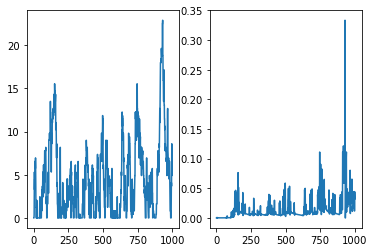

maximum steps, simulation is done ... 
elapsed_time: 51.764
Episode: 201 Exploration P: 0.0299 Total reward: -105.30722976949802 SOC: 0.6023 Cumulative_SOC_deviation: 17.4312 Fuel Consumption: 18.1511

maximum steps, simulation is done ... 
elapsed_time: 51.241
Episode: 202 Exploration P: 0.0295 Total reward: -49.201815650166324 SOC: 0.5912 Cumulative_SOC_deviation: 6.0467 Fuel Consumption: 18.9684

maximum steps, simulation is done ... 
elapsed_time: 51.853
Episode: 203 Exploration P: 0.0291 Total reward: -36.5389756902685 SOC: 0.5967 Cumulative_SOC_deviation: 5.9250 Fuel Consumption: 6.9139

maximum steps, simulation is done ... 
elapsed_time: 51.674
Episode: 204 Exploration P: 0.0288 Total reward: -76.00232310564462 SOC: 0.5916 Cumulative_SOC_deviation: 12.7036 Fuel Consumption: 12.4845

maximum steps, simulation is done ... 
elapsed_time: 51.069
Episode: 205 Exploration P: 0.0284 Total reward: -107.22555228714823 SOC: 0.5771 Cumulative_SOC_deviation: 18.3642 Fuel Consumption: 15.40

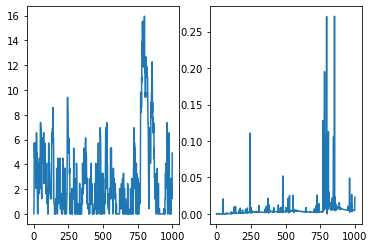

maximum steps, simulation is done ... 
elapsed_time: 51.605
Episode: 211 Exploration P: 0.0263 Total reward: -81.93465245033993 SOC: 0.5814 Cumulative_SOC_deviation: 14.5925 Fuel Consumption: 8.9722

maximum steps, simulation is done ... 
elapsed_time: 51.153
Episode: 212 Exploration P: 0.0260 Total reward: -74.77607706969755 SOC: 0.5835 Cumulative_SOC_deviation: 13.7046 Fuel Consumption: 6.2531

maximum steps, simulation is done ... 
elapsed_time: 51.722
Episode: 213 Exploration P: 0.0257 Total reward: -102.6178366889045 SOC: 0.5824 Cumulative_SOC_deviation: 17.6808 Fuel Consumption: 14.2136

maximum steps, simulation is done ... 
elapsed_time: 51.885
Episode: 214 Exploration P: 0.0254 Total reward: -66.28582786966034 SOC: 0.5475 Cumulative_SOC_deviation: 11.1629 Fuel Consumption: 10.4712

maximum steps, simulation is done ... 
elapsed_time: 51.093
Episode: 215 Exploration P: 0.0250 Total reward: -97.02079736241397 SOC: 0.5731 Cumulative_SOC_deviation: 17.5354 Fuel Consumption: 9.3437

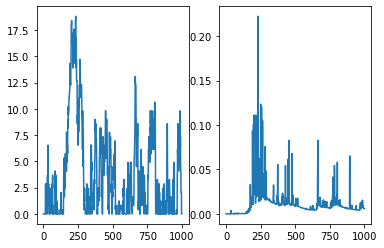

maximum steps, simulation is done ... 
elapsed_time: 51.903
Episode: 221 Exploration P: 0.0233 Total reward: -30.84102389000501 SOC: 0.5980 Cumulative_SOC_deviation: 4.9815 Fuel Consumption: 5.9338

maximum steps, simulation is done ... 
elapsed_time: 51.187
Episode: 222 Exploration P: 0.0231 Total reward: -66.91952935862439 SOC: 0.6048 Cumulative_SOC_deviation: 10.3603 Fuel Consumption: 15.1180

maximum steps, simulation is done ... 
elapsed_time: 51.882
Episode: 223 Exploration P: 0.0228 Total reward: -85.59028655578437 SOC: 0.5917 Cumulative_SOC_deviation: 13.5483 Fuel Consumption: 17.8488

maximum steps, simulation is done ... 
elapsed_time: 52.006
Episode: 224 Exploration P: 0.0226 Total reward: -43.61761730286149 SOC: 0.5835 Cumulative_SOC_deviation: 7.4515 Fuel Consumption: 6.3601

maximum steps, simulation is done ... 
elapsed_time: 51.455
Episode: 225 Exploration P: 0.0223 Total reward: -76.52164230419487 SOC: 0.6004 Cumulative_SOC_deviation: 12.6079 Fuel Consumption: 13.4819


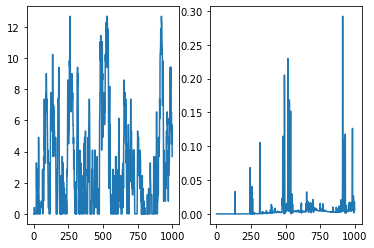

maximum steps, simulation is done ... 
elapsed_time: 51.827
Episode: 231 Exploration P: 0.0209 Total reward: -153.56584449269883 SOC: 0.5642 Cumulative_SOC_deviation: 28.8667 Fuel Consumption: 9.2323

maximum steps, simulation is done ... 
elapsed_time: 51.256
Episode: 232 Exploration P: 0.0207 Total reward: -62.00575811645905 SOC: 0.5736 Cumulative_SOC_deviation: 11.5193 Fuel Consumption: 4.4091

maximum steps, simulation is done ... 
elapsed_time: 51.686
Episode: 233 Exploration P: 0.0205 Total reward: -133.48666872537578 SOC: 0.5705 Cumulative_SOC_deviation: 24.7813 Fuel Consumption: 9.5804

maximum steps, simulation is done ... 
elapsed_time: 51.756
Episode: 234 Exploration P: 0.0203 Total reward: -152.8940247753567 SOC: 0.5239 Cumulative_SOC_deviation: 27.6342 Fuel Consumption: 14.7231

maximum steps, simulation is done ... 
elapsed_time: 51.824
Episode: 235 Exploration P: 0.0201 Total reward: -231.58439799707136 SOC: 0.5314 Cumulative_SOC_deviation: 45.7523 Fuel Consumption: 2.82

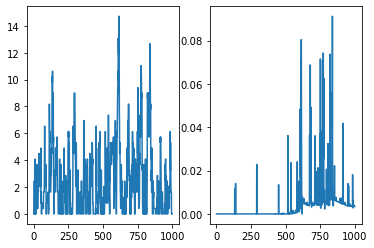

maximum steps, simulation is done ... 
elapsed_time: 51.514
Episode: 241 Exploration P: 0.0189 Total reward: -201.61686248151202 SOC: 0.5590 Cumulative_SOC_deviation: 37.2697 Fuel Consumption: 15.2685

maximum steps, simulation is done ... 
elapsed_time: 52.019
Episode: 242 Exploration P: 0.0188 Total reward: -131.1026798329139 SOC: 0.5480 Cumulative_SOC_deviation: 22.4026 Fuel Consumption: 19.0898

maximum steps, simulation is done ... 
elapsed_time: 51.931
Episode: 243 Exploration P: 0.0186 Total reward: -200.09357031198905 SOC: 0.5549 Cumulative_SOC_deviation: 38.5227 Fuel Consumption: 7.4799

maximum steps, simulation is done ... 
elapsed_time: 51.842
Episode: 244 Exploration P: 0.0184 Total reward: -327.8491917901503 SOC: 0.4887 Cumulative_SOC_deviation: 65.1396 Fuel Consumption: 2.1514

maximum steps, simulation is done ... 
elapsed_time: 51.764
Episode: 245 Exploration P: 0.0183 Total reward: -424.75238212126646 SOC: 0.3872 Cumulative_SOC_deviation: 83.8990 Fuel Consumption: 5.2

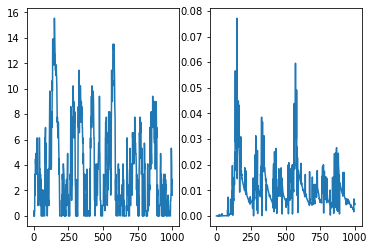

maximum steps, simulation is done ... 
elapsed_time: 51.065
Episode: 251 Exploration P: 0.0173 Total reward: -39.39835435055711 SOC: 0.5937 Cumulative_SOC_deviation: 6.9671 Fuel Consumption: 4.5630

maximum steps, simulation is done ... 
elapsed_time: 51.952
Episode: 252 Exploration P: 0.0172 Total reward: -80.64298369244207 SOC: 0.5942 Cumulative_SOC_deviation: 13.8308 Fuel Consumption: 11.4892

maximum steps, simulation is done ... 
elapsed_time: 51.938
Episode: 253 Exploration P: 0.0170 Total reward: -665.3794670742833 SOC: 0.5162 Cumulative_SOC_deviation: 118.7291 Fuel Consumption: 71.7341

maximum steps, simulation is done ... 
elapsed_time: 51.895
Episode: 254 Exploration P: 0.0169 Total reward: -209.48503245432704 SOC: 0.5303 Cumulative_SOC_deviation: 40.6071 Fuel Consumption: 6.4497

maximum steps, simulation is done ... 
elapsed_time: 51.676
Episode: 255 Exploration P: 0.0168 Total reward: -92.89386252946554 SOC: 0.5864 Cumulative_SOC_deviation: 16.9229 Fuel Consumption: 8.279

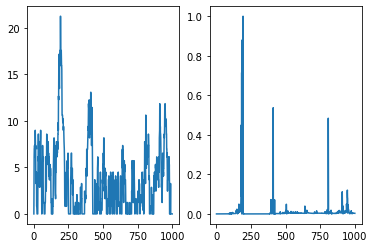

maximum steps, simulation is done ... 
elapsed_time: 50.906
Episode: 261 Exploration P: 0.0160 Total reward: -137.48018197147056 SOC: 0.5656 Cumulative_SOC_deviation: 25.8471 Fuel Consumption: 8.2448

maximum steps, simulation is done ... 
elapsed_time: 52.012
Episode: 262 Exploration P: 0.0159 Total reward: -95.33908788530313 SOC: 0.5793 Cumulative_SOC_deviation: 17.4317 Fuel Consumption: 8.1804

maximum steps, simulation is done ... 
elapsed_time: 51.725
Episode: 263 Exploration P: 0.0158 Total reward: -315.91237217094323 SOC: 0.4385 Cumulative_SOC_deviation: 62.2132 Fuel Consumption: 4.8465

maximum steps, simulation is done ... 
elapsed_time: 52.387
Episode: 264 Exploration P: 0.0156 Total reward: -271.38065703167047 SOC: 0.4742 Cumulative_SOC_deviation: 53.6698 Fuel Consumption: 3.0316

maximum steps, simulation is done ... 
elapsed_time: 51.829
Episode: 265 Exploration P: 0.0155 Total reward: -403.85938822688337 SOC: 0.4492 Cumulative_SOC_deviation: 79.9386 Fuel Consumption: 4.16

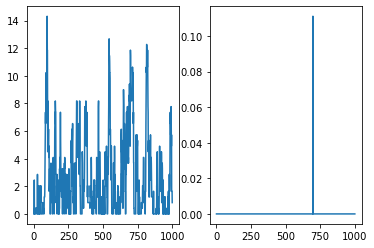

maximum steps, simulation is done ... 
elapsed_time: 50.901
Episode: 271 Exploration P: 0.0149 Total reward: -264.93920344021655 SOC: 0.4363 Cumulative_SOC_deviation: 52.3320 Fuel Consumption: 3.2792

maximum steps, simulation is done ... 
elapsed_time: 51.870
Episode: 272 Exploration P: 0.0148 Total reward: -362.8578564254263 SOC: 0.4612 Cumulative_SOC_deviation: 72.1592 Fuel Consumption: 2.0617

maximum steps, simulation is done ... 
elapsed_time: 51.801
Episode: 273 Exploration P: 0.0147 Total reward: -619.1611253154696 SOC: 0.4117 Cumulative_SOC_deviation: 123.1557 Fuel Consumption: 3.3824

maximum steps, simulation is done ... 
elapsed_time: 51.815
Episode: 274 Exploration P: 0.0146 Total reward: -396.9336608851317 SOC: 0.4827 Cumulative_SOC_deviation: 78.7742 Fuel Consumption: 3.0625

maximum steps, simulation is done ... 
elapsed_time: 51.635
Episode: 275 Exploration P: 0.0145 Total reward: -356.8614618359812 SOC: 0.4758 Cumulative_SOC_deviation: 70.5225 Fuel Consumption: 4.2491

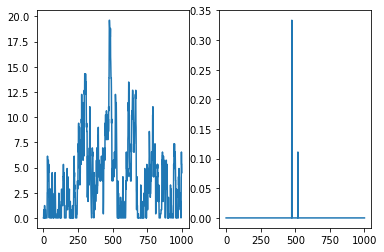

maximum steps, simulation is done ... 
elapsed_time: 50.798
Episode: 281 Exploration P: 0.0140 Total reward: -210.49808699022842 SOC: 0.4805 Cumulative_SOC_deviation: 41.7389 Fuel Consumption: 1.8037

maximum steps, simulation is done ... 
elapsed_time: 51.550
Episode: 282 Exploration P: 0.0139 Total reward: -368.33411336681206 SOC: 0.4674 Cumulative_SOC_deviation: 73.2112 Fuel Consumption: 2.2784

maximum steps, simulation is done ... 
elapsed_time: 51.611
Episode: 283 Exploration P: 0.0139 Total reward: -286.9797327487476 SOC: 0.4584 Cumulative_SOC_deviation: 57.0579 Fuel Consumption: 1.6902

maximum steps, simulation is done ... 
elapsed_time: 51.627
Episode: 284 Exploration P: 0.0138 Total reward: -574.7497324652518 SOC: 0.4355 Cumulative_SOC_deviation: 114.2322 Fuel Consumption: 3.5888

maximum steps, simulation is done ... 
elapsed_time: 51.502
Episode: 285 Exploration P: 0.0137 Total reward: -182.65225055544678 SOC: 0.5248 Cumulative_SOC_deviation: 35.9613 Fuel Consumption: 2.84

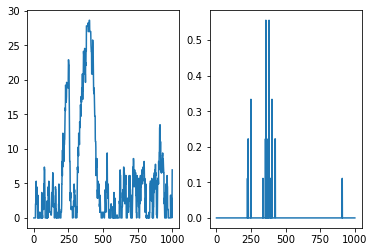

maximum steps, simulation is done ... 
elapsed_time: 50.959
Episode: 291 Exploration P: 0.0133 Total reward: -338.8011828326334 SOC: 0.4589 Cumulative_SOC_deviation: 67.5068 Fuel Consumption: 1.2672

maximum steps, simulation is done ... 
elapsed_time: 51.510
Episode: 292 Exploration P: 0.0132 Total reward: -592.1103483053421 SOC: 0.3415 Cumulative_SOC_deviation: 117.7332 Fuel Consumption: 3.4443

maximum steps, simulation is done ... 
elapsed_time: 51.566
Episode: 293 Exploration P: 0.0132 Total reward: -401.9962459727692 SOC: 0.4521 Cumulative_SOC_deviation: 79.9725 Fuel Consumption: 2.1339

maximum steps, simulation is done ... 
elapsed_time: 51.932
Episode: 294 Exploration P: 0.0131 Total reward: -335.5918090982176 SOC: 0.4411 Cumulative_SOC_deviation: 66.7556 Fuel Consumption: 1.8140

maximum steps, simulation is done ... 
elapsed_time: 51.764
Episode: 295 Exploration P: 0.0130 Total reward: -166.77146145496636 SOC: 0.4525 Cumulative_SOC_deviation: 32.6716 Fuel Consumption: 3.4134

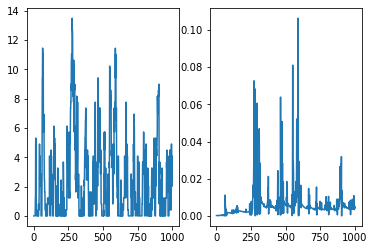

maximum steps, simulation is done ... 
elapsed_time: 51.008
Episode: 301 Exploration P: 0.0127 Total reward: -58.38738649529996 SOC: 0.5984 Cumulative_SOC_deviation: 9.5911 Fuel Consumption: 10.4321

maximum steps, simulation is done ... 
elapsed_time: 51.152
Episode: 302 Exploration P: 0.0126 Total reward: -36.26769807437192 SOC: 0.5948 Cumulative_SOC_deviation: 5.1667 Fuel Consumption: 10.4340

maximum steps, simulation is done ... 
elapsed_time: 51.707
Episode: 303 Exploration P: 0.0126 Total reward: -48.96962769950777 SOC: 0.5828 Cumulative_SOC_deviation: 8.6189 Fuel Consumption: 5.8749

maximum steps, simulation is done ... 
elapsed_time: 51.573
Episode: 304 Exploration P: 0.0125 Total reward: -74.43385747070444 SOC: 0.5926 Cumulative_SOC_deviation: 12.7056 Fuel Consumption: 10.9060

maximum steps, simulation is done ... 
elapsed_time: 51.581
Episode: 305 Exploration P: 0.0125 Total reward: -72.38044294308375 SOC: 0.5635 Cumulative_SOC_deviation: 13.4294 Fuel Consumption: 5.2337



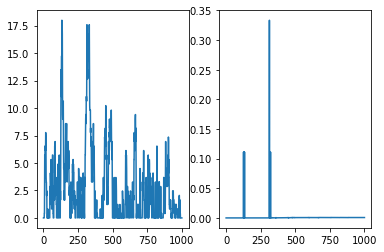

maximum steps, simulation is done ... 
elapsed_time: 51.153
Episode: 311 Exploration P: 0.0122 Total reward: -275.0171707903454 SOC: 0.4811 Cumulative_SOC_deviation: 54.1687 Fuel Consumption: 4.1739

maximum steps, simulation is done ... 
elapsed_time: 51.775
Episode: 312 Exploration P: 0.0122 Total reward: -309.358822267309 SOC: 0.5007 Cumulative_SOC_deviation: 61.3322 Fuel Consumption: 2.6980

maximum steps, simulation is done ... 
elapsed_time: 51.684
Episode: 313 Exploration P: 0.0121 Total reward: -270.5917534108772 SOC: 0.5056 Cumulative_SOC_deviation: 53.8195 Fuel Consumption: 1.4943

maximum steps, simulation is done ... 
elapsed_time: 51.925
Episode: 314 Exploration P: 0.0121 Total reward: -776.9888346872284 SOC: 0.3641 Cumulative_SOC_deviation: 154.7685 Fuel Consumption: 3.1463

maximum steps, simulation is done ... 
elapsed_time: 51.667
Episode: 315 Exploration P: 0.0120 Total reward: -234.42579506652655 SOC: 0.5185 Cumulative_SOC_deviation: 46.6957 Fuel Consumption: 0.9474


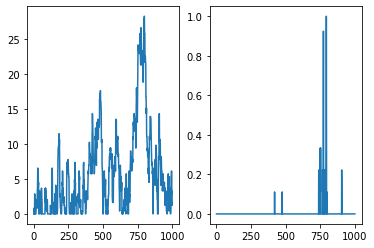

maximum steps, simulation is done ... 
elapsed_time: 50.878
Episode: 321 Exploration P: 0.0118 Total reward: -557.5472683092786 SOC: 0.4068 Cumulative_SOC_deviation: 110.9568 Fuel Consumption: 2.7633

maximum steps, simulation is done ... 
elapsed_time: 51.770
Episode: 322 Exploration P: 0.0118 Total reward: -275.0437253252901 SOC: 0.4908 Cumulative_SOC_deviation: 54.6480 Fuel Consumption: 1.8037

maximum steps, simulation is done ... 
elapsed_time: 51.803
Episode: 323 Exploration P: 0.0117 Total reward: -418.1808341913529 SOC: 0.3556 Cumulative_SOC_deviation: 82.8668 Fuel Consumption: 3.8467

maximum steps, simulation is done ... 
elapsed_time: 52.183
Episode: 324 Exploration P: 0.0117 Total reward: -400.6695302219647 SOC: 0.4682 Cumulative_SOC_deviation: 79.9713 Fuel Consumption: 0.8132

maximum steps, simulation is done ... 
elapsed_time: 51.943
Episode: 325 Exploration P: 0.0117 Total reward: -194.56400655639302 SOC: 0.5234 Cumulative_SOC_deviation: 38.6841 Fuel Consumption: 1.1434

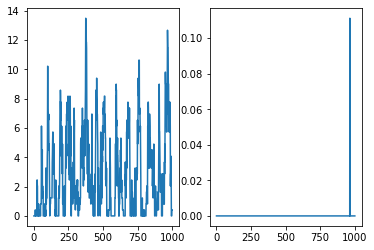

maximum steps, simulation is done ... 
elapsed_time: 51.103
Episode: 331 Exploration P: 0.0115 Total reward: -355.5881738008135 SOC: 0.3946 Cumulative_SOC_deviation: 70.8477 Fuel Consumption: 1.3497

maximum steps, simulation is done ... 
elapsed_time: 52.055
Episode: 332 Exploration P: 0.0114 Total reward: -515.5770121600906 SOC: 0.4168 Cumulative_SOC_deviation: 102.7258 Fuel Consumption: 1.9482

maximum steps, simulation is done ... 
elapsed_time: 52.077
Episode: 333 Exploration P: 0.0114 Total reward: -516.5215082761274 SOC: 0.3826 Cumulative_SOC_deviation: 102.6237 Fuel Consumption: 3.4030

maximum steps, simulation is done ... 
elapsed_time: 51.806
Episode: 334 Exploration P: 0.0114 Total reward: -131.92467099403487 SOC: 0.5936 Cumulative_SOC_deviation: 24.7173 Fuel Consumption: 8.3380

maximum steps, simulation is done ... 
elapsed_time: 51.852
Episode: 335 Exploration P: 0.0114 Total reward: -63.495854717870365 SOC: 0.5835 Cumulative_SOC_deviation: 11.4234 Fuel Consumption: 6.37

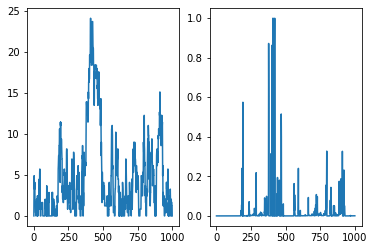

maximum steps, simulation is done ... 
elapsed_time: 51.585
Episode: 341 Exploration P: 0.0112 Total reward: -84.87448402521838 SOC: 0.5437 Cumulative_SOC_deviation: 15.0465 Fuel Consumption: 9.6419

maximum steps, simulation is done ... 
elapsed_time: 51.906
Episode: 342 Exploration P: 0.0112 Total reward: -207.8003739230515 SOC: 0.5521 Cumulative_SOC_deviation: 38.2192 Fuel Consumption: 16.7044

maximum steps, simulation is done ... 
elapsed_time: 51.954
Episode: 343 Exploration P: 0.0112 Total reward: -114.60968117884464 SOC: 0.5620 Cumulative_SOC_deviation: 21.0340 Fuel Consumption: 9.4398

maximum steps, simulation is done ... 
elapsed_time: 51.892
Episode: 344 Exploration P: 0.0111 Total reward: -66.6218971157414 SOC: 0.5632 Cumulative_SOC_deviation: 11.5764 Fuel Consumption: 8.7400

maximum steps, simulation is done ... 
elapsed_time: 52.052
Episode: 345 Exploration P: 0.0111 Total reward: -147.0598063761736 SOC: 0.5514 Cumulative_SOC_deviation: 26.9710 Fuel Consumption: 12.2050

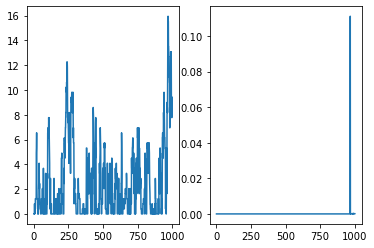

maximum steps, simulation is done ... 
elapsed_time: 51.747
Episode: 351 Exploration P: 0.0110 Total reward: -272.50516067645515 SOC: 0.4726 Cumulative_SOC_deviation: 54.1906 Fuel Consumption: 1.5523

maximum steps, simulation is done ... 
elapsed_time: 51.958
Episode: 352 Exploration P: 0.0110 Total reward: -329.8249576822336 SOC: 0.4877 Cumulative_SOC_deviation: 65.6824 Fuel Consumption: 1.4129

maximum steps, simulation is done ... 
elapsed_time: 52.064
Episode: 353 Exploration P: 0.0109 Total reward: -253.7322425505476 SOC: 0.4881 Cumulative_SOC_deviation: 50.3107 Fuel Consumption: 2.1788

maximum steps, simulation is done ... 
elapsed_time: 51.689
Episode: 354 Exploration P: 0.0109 Total reward: -566.532475368643 SOC: 0.4088 Cumulative_SOC_deviation: 112.8394 Fuel Consumption: 2.3354

maximum steps, simulation is done ... 
elapsed_time: 51.857
Episode: 355 Exploration P: 0.0109 Total reward: -238.47988357464325 SOC: 0.5066 Cumulative_SOC_deviation: 47.4115 Fuel Consumption: 1.4222

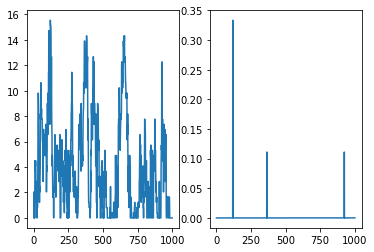

maximum steps, simulation is done ... 
elapsed_time: 51.851
Episode: 361 Exploration P: 0.0108 Total reward: -278.76529046724715 SOC: 0.4744 Cumulative_SOC_deviation: 55.0268 Fuel Consumption: 3.6311

maximum steps, simulation is done ... 
elapsed_time: 51.954
Episode: 362 Exploration P: 0.0108 Total reward: -298.4105188866757 SOC: 0.4869 Cumulative_SOC_deviation: 59.3048 Fuel Consumption: 1.8864

maximum steps, simulation is done ... 
elapsed_time: 52.065
Episode: 363 Exploration P: 0.0108 Total reward: -294.788266139897 SOC: 0.4273 Cumulative_SOC_deviation: 58.2521 Fuel Consumption: 3.5276

maximum steps, simulation is done ... 
elapsed_time: 51.941
Episode: 364 Exploration P: 0.0108 Total reward: -118.71167521065392 SOC: 0.5400 Cumulative_SOC_deviation: 23.2702 Fuel Consumption: 2.3609

maximum steps, simulation is done ... 
elapsed_time: 51.837
Episode: 365 Exploration P: 0.0107 Total reward: -424.0409550741202 SOC: 0.4463 Cumulative_SOC_deviation: 84.5094 Fuel Consumption: 1.4942


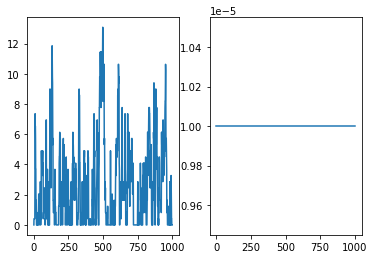

maximum steps, simulation is done ... 
elapsed_time: 51.932
Episode: 371 Exploration P: 0.0107 Total reward: -399.903977417334 SOC: 0.4557 Cumulative_SOC_deviation: 79.7005 Fuel Consumption: 1.4013

maximum steps, simulation is done ... 
elapsed_time: 51.696
Episode: 372 Exploration P: 0.0106 Total reward: -233.4858014073413 SOC: 0.3549 Cumulative_SOC_deviation: 45.9588 Fuel Consumption: 3.6919

maximum steps, simulation is done ... 
elapsed_time: 51.956
Episode: 373 Exploration P: 0.0106 Total reward: -136.7568639396441 SOC: 0.5348 Cumulative_SOC_deviation: 27.0525 Fuel Consumption: 1.4942

maximum steps, simulation is done ... 
elapsed_time: 51.673
Episode: 374 Exploration P: 0.0106 Total reward: -425.9075034243955 SOC: 0.3139 Cumulative_SOC_deviation: 83.0168 Fuel Consumption: 10.8233

maximum steps, simulation is done ... 
elapsed_time: 51.976
Episode: 375 Exploration P: 0.0106 Total reward: -306.1856989568874 SOC: 0.4921 Cumulative_SOC_deviation: 61.0374 Fuel Consumption: 0.9989



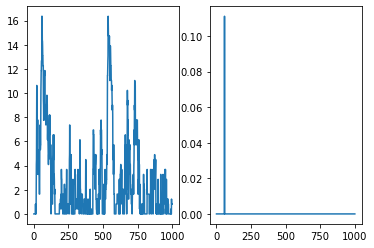

maximum steps, simulation is done ... 
elapsed_time: 51.857
Episode: 381 Exploration P: 0.0105 Total reward: -1082.3332249041987 SOC: 0.3616 Cumulative_SOC_deviation: 213.9289 Fuel Consumption: 12.6888

maximum steps, simulation is done ... 
elapsed_time: 51.545
Episode: 382 Exploration P: 0.0105 Total reward: -404.4183049785992 SOC: 0.4627 Cumulative_SOC_deviation: 80.3578 Fuel Consumption: 2.6292

maximum steps, simulation is done ... 
elapsed_time: 51.971
Episode: 383 Exploration P: 0.0105 Total reward: -163.06954654637957 SOC: 0.5233 Cumulative_SOC_deviation: 32.4657 Fuel Consumption: 0.7410

maximum steps, simulation is done ... 
elapsed_time: 51.834
Episode: 384 Exploration P: 0.0105 Total reward: -191.08927558596505 SOC: 0.5008 Cumulative_SOC_deviation: 37.7952 Fuel Consumption: 2.1133

maximum steps, simulation is done ... 
elapsed_time: 51.915
Episode: 385 Exploration P: 0.0105 Total reward: -77.93011678173019 SOC: 0.5155 Cumulative_SOC_deviation: 14.9095 Fuel Consumption: 3.3

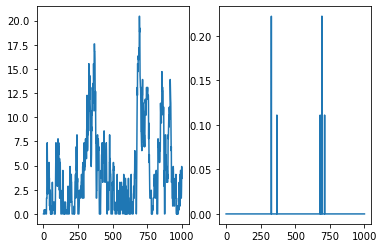

maximum steps, simulation is done ... 
elapsed_time: 51.752
Episode: 391 Exploration P: 0.0104 Total reward: -337.60648147304624 SOC: 0.4722 Cumulative_SOC_deviation: 67.1110 Fuel Consumption: 2.0514

maximum steps, simulation is done ... 
elapsed_time: 51.873
Episode: 392 Exploration P: 0.0104 Total reward: -116.96989094626136 SOC: 0.5964 Cumulative_SOC_deviation: 20.3203 Fuel Consumption: 15.3684

maximum steps, simulation is done ... 
elapsed_time: 51.930
Episode: 393 Exploration P: 0.0104 Total reward: -32.33041943888467 SOC: 0.6056 Cumulative_SOC_deviation: 3.5265 Fuel Consumption: 14.6977

maximum steps, simulation is done ... 
elapsed_time: 51.988
Episode: 394 Exploration P: 0.0104 Total reward: -33.33632949299782 SOC: 0.6030 Cumulative_SOC_deviation: 4.9321 Fuel Consumption: 8.6759

maximum steps, simulation is done ... 
elapsed_time: 51.929
Episode: 395 Exploration P: 0.0104 Total reward: -96.73114975825223 SOC: 0.5847 Cumulative_SOC_deviation: 15.6938 Fuel Consumption: 18.262

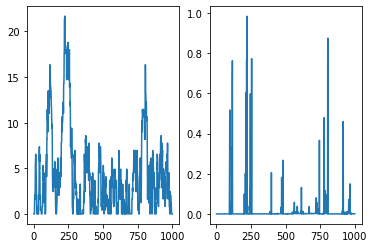

model is saved..

Trial 6

maximum steps, simulation is done ... 
elapsed_time: 8.244
Episode: 1 Exploration P: 1.0000 Total reward: -2213.848877842717 SOC: 1.0000 Cumulative_SOC_deviation: 352.1359 Fuel Consumption: 101.0333

maximum steps, simulation is done ... 
elapsed_time: 8.125
Episode: 2 Exploration P: 1.0000 Total reward: -2234.7243665427554 SOC: 0.9807 Cumulative_SOC_deviation: 353.6960 Fuel Consumption: 112.5483

maximum steps, simulation is done ... 
elapsed_time: 8.821
Episode: 3 Exploration P: 1.0000 Total reward: -2195.3887376774205 SOC: 1.0000 Cumulative_SOC_deviation: 349.2914 Fuel Consumption: 99.6403

maximum steps, simulation is done ... 
elapsed_time: 8.984
Episode: 4 Exploration P: 1.0000 Total reward: -2219.046993122929 SOC: 1.0000 Cumulative_SOC_deviation: 353.1381 Fuel Consumption: 100.2181


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X mod

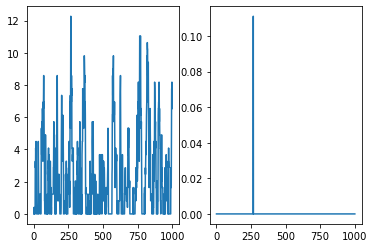

maximum steps, simulation is done ... 
elapsed_time: 51.104
Episode: 11 Exploration P: 0.8879 Total reward: -2190.455159256669 SOC: 1.0000 Cumulative_SOC_deviation: 349.4769 Fuel Consumption: 93.5939

maximum steps, simulation is done ... 
elapsed_time: 51.401
Episode: 12 Exploration P: 0.8705 Total reward: -2186.535681248626 SOC: 1.0000 Cumulative_SOC_deviation: 349.4324 Fuel Consumption: 89.9413

maximum steps, simulation is done ... 
elapsed_time: 51.385
Episode: 13 Exploration P: 0.8534 Total reward: -2146.299357418993 SOC: 1.0000 Cumulative_SOC_deviation: 343.0221 Fuel Consumption: 88.1665

maximum steps, simulation is done ... 
elapsed_time: 49.811
Episode: 14 Exploration P: 0.8367 Total reward: -2162.3726485683655 SOC: 0.9920 Cumulative_SOC_deviation: 345.5394 Fuel Consumption: 89.1364

maximum steps, simulation is done ... 
elapsed_time: 48.852
Episode: 15 Exploration P: 0.8203 Total reward: -2147.0946459717447 SOC: 1.0000 Cumulative_SOC_deviation: 342.8641 Fuel Consumption: 89

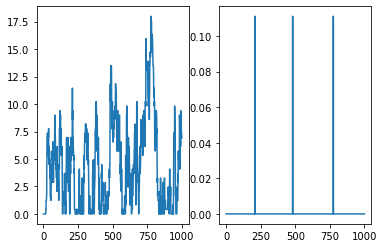

maximum steps, simulation is done ... 
elapsed_time: 51.584
Episode: 21 Exploration P: 0.7286 Total reward: -2108.8210078517836 SOC: 1.0000 Cumulative_SOC_deviation: 338.6038 Fuel Consumption: 77.1984

maximum steps, simulation is done ... 
elapsed_time: 51.599
Episode: 22 Exploration P: 0.7144 Total reward: -2037.2966644997066 SOC: 0.9999 Cumulative_SOC_deviation: 327.1955 Fuel Consumption: 74.1236

maximum steps, simulation is done ... 
elapsed_time: 51.470
Episode: 23 Exploration P: 0.7004 Total reward: -2087.7754330462612 SOC: 1.0000 Cumulative_SOC_deviation: 333.6637 Fuel Consumption: 85.7934

maximum steps, simulation is done ... 
elapsed_time: 51.373
Episode: 24 Exploration P: 0.6867 Total reward: -2107.5914805508137 SOC: 1.0000 Cumulative_SOC_deviation: 338.1375 Fuel Consumption: 78.7667

maximum steps, simulation is done ... 
elapsed_time: 51.452
Episode: 25 Exploration P: 0.6733 Total reward: -2109.5424152075493 SOC: 1.0000 Cumulative_SOC_deviation: 338.7808 Fuel Consumption:

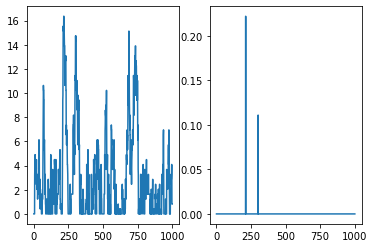

maximum steps, simulation is done ... 
elapsed_time: 51.900
Episode: 31 Exploration P: 0.5982 Total reward: -1955.561126783395 SOC: 1.0000 Cumulative_SOC_deviation: 314.9968 Fuel Consumption: 65.5801

maximum steps, simulation is done ... 
elapsed_time: 51.522
Episode: 32 Exploration P: 0.5866 Total reward: -2000.9621977771114 SOC: 1.0000 Cumulative_SOC_deviation: 322.6084 Fuel Consumption: 65.3119

maximum steps, simulation is done ... 
elapsed_time: 51.850
Episode: 33 Exploration P: 0.5751 Total reward: -1948.9071505796478 SOC: 0.9992 Cumulative_SOC_deviation: 314.1888 Fuel Consumption: 63.7745

maximum steps, simulation is done ... 
elapsed_time: 51.810
Episode: 34 Exploration P: 0.5639 Total reward: -1971.6965853849722 SOC: 1.0000 Cumulative_SOC_deviation: 317.5726 Fuel Consumption: 66.2611

maximum steps, simulation is done ... 
elapsed_time: 51.776
Episode: 35 Exploration P: 0.5530 Total reward: -1942.0642118669077 SOC: 1.0000 Cumulative_SOC_deviation: 313.5608 Fuel Consumption: 

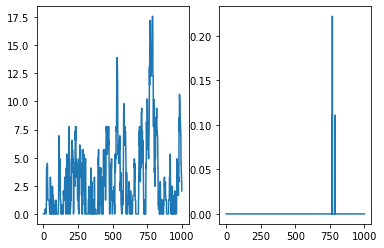

maximum steps, simulation is done ... 
elapsed_time: 52.080
Episode: 41 Exploration P: 0.4915 Total reward: -1749.86715932838 SOC: 0.9998 Cumulative_SOC_deviation: 283.2734 Fuel Consumption: 50.2267

maximum steps, simulation is done ... 
elapsed_time: 51.829
Episode: 42 Exploration P: 0.4820 Total reward: -1650.0365640518671 SOC: 0.9991 Cumulative_SOC_deviation: 263.2059 Fuel Consumption: 70.8011

maximum steps, simulation is done ... 
elapsed_time: 51.940
Episode: 43 Exploration P: 0.4726 Total reward: -1742.6558422818875 SOC: 0.9992 Cumulative_SOC_deviation: 281.8772 Fuel Consumption: 51.3927

maximum steps, simulation is done ... 
elapsed_time: 52.243
Episode: 44 Exploration P: 0.4634 Total reward: -1802.30996350211 SOC: 0.9964 Cumulative_SOC_deviation: 291.6734 Fuel Consumption: 52.2697

maximum steps, simulation is done ... 
elapsed_time: 51.572
Episode: 45 Exploration P: 0.4544 Total reward: -1634.5090968116822 SOC: 0.9995 Cumulative_SOC_deviation: 263.2233 Fuel Consumption: 55.

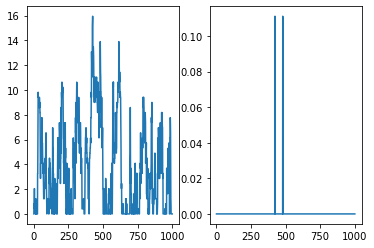

maximum steps, simulation is done ... 
elapsed_time: 52.205
Episode: 51 Exploration P: 0.4041 Total reward: -1549.0716526883205 SOC: 1.0000 Cumulative_SOC_deviation: 248.9287 Fuel Consumption: 55.4993

maximum steps, simulation is done ... 
elapsed_time: 51.890
Episode: 52 Exploration P: 0.3963 Total reward: -1673.736007792196 SOC: 0.9985 Cumulative_SOC_deviation: 271.0853 Fuel Consumption: 47.2242

maximum steps, simulation is done ... 
elapsed_time: 51.947
Episode: 53 Exploration P: 0.3887 Total reward: -1660.9581957476294 SOC: 1.0000 Cumulative_SOC_deviation: 269.1242 Fuel Consumption: 46.2130

maximum steps, simulation is done ... 
elapsed_time: 51.846
Episode: 54 Exploration P: 0.3812 Total reward: -1567.817032751739 SOC: 1.0000 Cumulative_SOC_deviation: 252.9747 Fuel Consumption: 49.9688

maximum steps, simulation is done ... 
elapsed_time: 52.178
Episode: 55 Exploration P: 0.3738 Total reward: -1628.866439927089 SOC: 1.0000 Cumulative_SOC_deviation: 263.7481 Fuel Consumption: 46

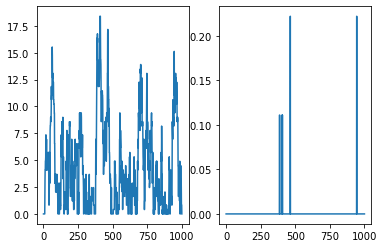

maximum steps, simulation is done ... 
elapsed_time: 51.731
Episode: 61 Exploration P: 0.3326 Total reward: -1407.6904692917908 SOC: 1.0000 Cumulative_SOC_deviation: 228.0875 Fuel Consumption: 39.1657

maximum steps, simulation is done ... 
elapsed_time: 52.034
Episode: 62 Exploration P: 0.3262 Total reward: -1423.0292792348298 SOC: 0.9299 Cumulative_SOC_deviation: 228.9260 Fuel Consumption: 49.4735

maximum steps, simulation is done ... 
elapsed_time: 51.984
Episode: 63 Exploration P: 0.3200 Total reward: -1308.038146705602 SOC: 0.9921 Cumulative_SOC_deviation: 211.5200 Fuel Consumption: 38.9181

maximum steps, simulation is done ... 
elapsed_time: 52.246
Episode: 64 Exploration P: 0.3138 Total reward: -1270.3247158784739 SOC: 0.9641 Cumulative_SOC_deviation: 204.5810 Fuel Consumption: 42.8390

maximum steps, simulation is done ... 
elapsed_time: 51.668
Episode: 65 Exploration P: 0.3078 Total reward: -1230.9878911193227 SOC: 0.9904 Cumulative_SOC_deviation: 198.1504 Fuel Consumption: 

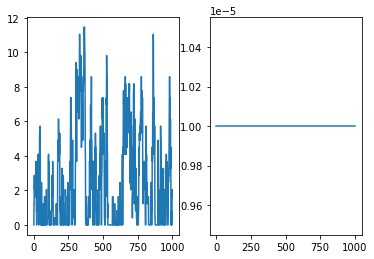

maximum steps, simulation is done ... 
elapsed_time: 52.137
Episode: 71 Exploration P: 0.2741 Total reward: -1132.9950494703248 SOC: 0.9381 Cumulative_SOC_deviation: 182.9463 Fuel Consumption: 35.3170

maximum steps, simulation is done ... 
elapsed_time: 52.395
Episode: 72 Exploration P: 0.2689 Total reward: -1192.3531863910769 SOC: 0.9037 Cumulative_SOC_deviation: 190.8927 Fuel Consumption: 46.9972

battery power is 110097.88607784062(+) but condition is not avail
elapsed_time: 9.387
Episode: 73 Exploration P: 0.2679 Total reward: -1031.3211159351044 SOC: 0.5300 Cumulative_SOC_deviation: 3.6614 Fuel Consumption: 9.7728

maximum steps, simulation is done ... 
elapsed_time: 52.347
Episode: 74 Exploration P: 0.2628 Total reward: -743.8296450920272 SOC: 0.8212 Cumulative_SOC_deviation: 117.1826 Fuel Consumption: 40.7341

maximum steps, simulation is done ... 
elapsed_time: 52.282
Episode: 75 Exploration P: 0.2578 Total reward: -1016.3050111498583 SOC: 0.8954 Cumulative_SOC_deviation: 163.

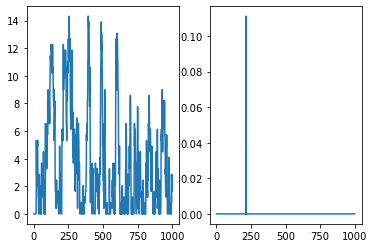

maximum steps, simulation is done ... 
elapsed_time: 51.359
Episode: 81 Exploration P: 0.2298 Total reward: -1011.215756402136 SOC: 0.9259 Cumulative_SOC_deviation: 162.9077 Fuel Consumption: 33.7693

maximum steps, simulation is done ... 
elapsed_time: 52.240
Episode: 82 Exploration P: 0.2254 Total reward: -902.3010674633498 SOC: 0.8483 Cumulative_SOC_deviation: 144.1809 Fuel Consumption: 37.2156

maximum steps, simulation is done ... 
elapsed_time: 51.845
Episode: 83 Exploration P: 0.2211 Total reward: -1014.0700886482956 SOC: 0.8651 Cumulative_SOC_deviation: 163.2390 Fuel Consumption: 34.6360

maximum steps, simulation is done ... 
elapsed_time: 52.325
Episode: 84 Exploration P: 0.2169 Total reward: -696.5611903846217 SOC: 0.8193 Cumulative_SOC_deviation: 110.6820 Fuel Consumption: 32.4692

maximum steps, simulation is done ... 
elapsed_time: 52.151
Episode: 85 Exploration P: 0.2128 Total reward: -879.0384020531433 SOC: 0.8418 Cumulative_SOC_deviation: 142.0493 Fuel Consumption: 26.

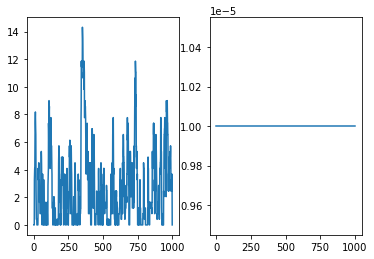

maximum steps, simulation is done ... 
elapsed_time: 51.449
Episode: 91 Exploration P: 0.1899 Total reward: -700.3290110194109 SOC: 0.8448 Cumulative_SOC_deviation: 112.1268 Fuel Consumption: 27.5681

maximum steps, simulation is done ... 
elapsed_time: 52.112
Episode: 92 Exploration P: 0.1863 Total reward: -795.1871313856715 SOC: 0.8417 Cumulative_SOC_deviation: 127.9829 Fuel Consumption: 27.2895

maximum steps, simulation is done ... 
elapsed_time: 51.979
Episode: 93 Exploration P: 0.1828 Total reward: -712.1660940660115 SOC: 0.8250 Cumulative_SOC_deviation: 114.4230 Fuel Consumption: 25.6283

maximum steps, simulation is done ... 
elapsed_time: 52.124
Episode: 94 Exploration P: 0.1794 Total reward: -546.9402378544471 SOC: 0.7971 Cumulative_SOC_deviation: 86.9111 Fuel Consumption: 25.4735

maximum steps, simulation is done ... 
elapsed_time: 52.330
Episode: 95 Exploration P: 0.1760 Total reward: -298.03446148596 SOC: 0.5067 Cumulative_SOC_deviation: 44.7321 Fuel Consumption: 29.6421


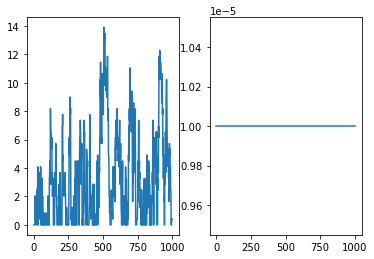

maximum steps, simulation is done ... 
elapsed_time: 51.345
Episode: 101 Exploration P: 0.1572 Total reward: -544.9517045508121 SOC: 0.7631 Cumulative_SOC_deviation: 87.3948 Fuel Consumption: 20.5827

maximum steps, simulation is done ... 
elapsed_time: 51.952
Episode: 102 Exploration P: 0.1543 Total reward: -483.630456099103 SOC: 0.7184 Cumulative_SOC_deviation: 77.0405 Fuel Consumption: 21.3875

maximum steps, simulation is done ... 
elapsed_time: 52.377
Episode: 103 Exploration P: 0.1515 Total reward: -354.3615925617705 SOC: 0.7605 Cumulative_SOC_deviation: 55.3082 Fuel Consumption: 22.5122

maximum steps, simulation is done ... 
elapsed_time: 52.107
Episode: 104 Exploration P: 0.1487 Total reward: -203.1133246313143 SOC: 0.6453 Cumulative_SOC_deviation: 29.7356 Fuel Consumption: 24.6997

maximum steps, simulation is done ... 
elapsed_time: 52.288
Episode: 105 Exploration P: 0.1459 Total reward: -635.2654732535079 SOC: 0.7166 Cumulative_SOC_deviation: 101.2588 Fuel Consumption: 27.7

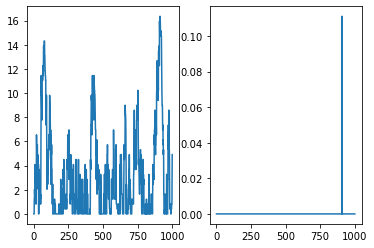

maximum steps, simulation is done ... 
elapsed_time: 51.398
Episode: 111 Exploration P: 0.1305 Total reward: -311.44309074899047 SOC: 0.7023 Cumulative_SOC_deviation: 49.0167 Fuel Consumption: 17.3428

maximum steps, simulation is done ... 
elapsed_time: 52.300
Episode: 112 Exploration P: 0.1281 Total reward: -129.7191486512708 SOC: 0.6381 Cumulative_SOC_deviation: 18.5058 Fuel Consumption: 18.6842

maximum steps, simulation is done ... 
elapsed_time: 52.039
Episode: 113 Exploration P: 0.1258 Total reward: -242.83265266789553 SOC: 0.6737 Cumulative_SOC_deviation: 37.6367 Fuel Consumption: 17.0127

maximum steps, simulation is done ... 
elapsed_time: 52.195
Episode: 114 Exploration P: 0.1235 Total reward: -122.79124038183679 SOC: 0.6348 Cumulative_SOC_deviation: 18.0253 Fuel Consumption: 14.6395

maximum steps, simulation is done ... 
elapsed_time: 51.871
Episode: 115 Exploration P: 0.1213 Total reward: -413.7970708523735 SOC: 0.7201 Cumulative_SOC_deviation: 66.0121 Fuel Consumption: 1

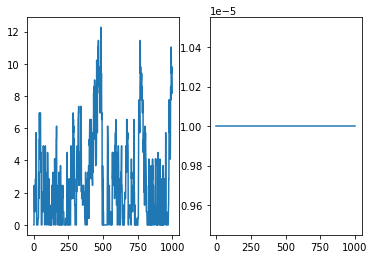

maximum steps, simulation is done ... 
elapsed_time: 51.787
Episode: 121 Exploration P: 0.1087 Total reward: -166.22955562504364 SOC: 0.5915 Cumulative_SOC_deviation: 25.4026 Fuel Consumption: 13.8140

maximum steps, simulation is done ... 
elapsed_time: 52.219
Episode: 122 Exploration P: 0.1067 Total reward: -179.16998616493495 SOC: 0.6640 Cumulative_SOC_deviation: 26.9471 Fuel Consumption: 17.4873

maximum steps, simulation is done ... 
elapsed_time: 52.232
Episode: 123 Exploration P: 0.1048 Total reward: -183.56485288415666 SOC: 0.6590 Cumulative_SOC_deviation: 28.1302 Fuel Consumption: 14.7839

maximum steps, simulation is done ... 
elapsed_time: 52.019
Episode: 124 Exploration P: 0.1029 Total reward: -209.60939254192934 SOC: 0.6917 Cumulative_SOC_deviation: 32.0633 Fuel Consumption: 17.2293

maximum steps, simulation is done ... 
elapsed_time: 51.973
Episode: 125 Exploration P: 0.1011 Total reward: -135.7913780744674 SOC: 0.5660 Cumulative_SOC_deviation: 19.8566 Fuel Consumption: 

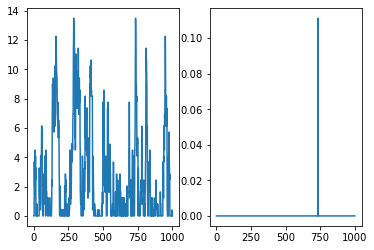

maximum steps, simulation is done ... 
elapsed_time: 51.363
Episode: 131 Exploration P: 0.0908 Total reward: -269.6651575281737 SOC: 0.4543 Cumulative_SOC_deviation: 41.9007 Fuel Consumption: 18.2612

maximum steps, simulation is done ... 
elapsed_time: 52.512
Episode: 132 Exploration P: 0.0892 Total reward: -197.5497884726079 SOC: 0.5622 Cumulative_SOC_deviation: 30.4352 Fuel Consumption: 14.9387

maximum steps, simulation is done ... 
elapsed_time: 52.200
Episode: 133 Exploration P: 0.0876 Total reward: -252.47924141703902 SOC: 0.6920 Cumulative_SOC_deviation: 39.5127 Fuel Consumption: 15.4030

maximum steps, simulation is done ... 
elapsed_time: 52.180
Episode: 134 Exploration P: 0.0861 Total reward: -92.8216367458781 SOC: 0.5929 Cumulative_SOC_deviation: 13.7372 Fuel Consumption: 10.3987

maximum steps, simulation is done ... 
elapsed_time: 52.087
Episode: 135 Exploration P: 0.0845 Total reward: -121.07115483222721 SOC: 0.5848 Cumulative_SOC_deviation: 18.3113 Fuel Consumption: 11.

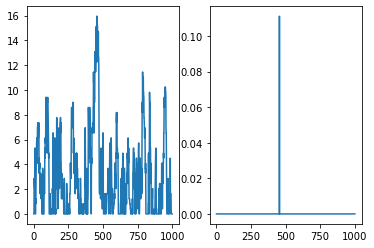

maximum steps, simulation is done ... 
elapsed_time: 51.572
Episode: 141 Exploration P: 0.0761 Total reward: -128.44850715367244 SOC: 0.6284 Cumulative_SOC_deviation: 19.8607 Fuel Consumption: 9.2844

maximum steps, simulation is done ... 
elapsed_time: 52.037
Episode: 142 Exploration P: 0.0748 Total reward: -177.24077844365658 SOC: 0.6607 Cumulative_SOC_deviation: 27.5903 Fuel Consumption: 11.6988

maximum steps, simulation is done ... 
elapsed_time: 51.938
Episode: 143 Exploration P: 0.0735 Total reward: -69.73641359433363 SOC: 0.6281 Cumulative_SOC_deviation: 9.9722 Fuel Consumption: 9.9035

maximum steps, simulation is done ... 
elapsed_time: 52.120
Episode: 144 Exploration P: 0.0723 Total reward: -69.4482663500828 SOC: 0.5790 Cumulative_SOC_deviation: 9.5888 Fuel Consumption: 11.9155

maximum steps, simulation is done ... 
elapsed_time: 52.166
Episode: 145 Exploration P: 0.0710 Total reward: -55.411021542893785 SOC: 0.6147 Cumulative_SOC_deviation: 7.5261 Fuel Consumption: 10.2543

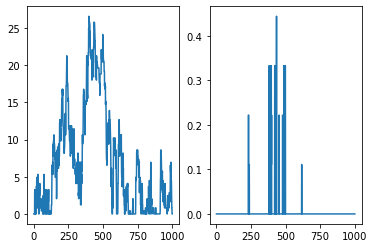

maximum steps, simulation is done ... 
elapsed_time: 51.198
Episode: 151 Exploration P: 0.0641 Total reward: -141.7856846320145 SOC: 0.6027 Cumulative_SOC_deviation: 22.2899 Fuel Consumption: 8.0462

maximum steps, simulation is done ... 
elapsed_time: 52.026
Episode: 152 Exploration P: 0.0630 Total reward: -132.11307124212126 SOC: 0.5497 Cumulative_SOC_deviation: 20.2393 Fuel Consumption: 10.6773

maximum steps, simulation is done ... 
elapsed_time: 52.321
Episode: 153 Exploration P: 0.0620 Total reward: -218.88512281295874 SOC: 0.5620 Cumulative_SOC_deviation: 34.4674 Fuel Consumption: 12.0806

maximum steps, simulation is done ... 
elapsed_time: 52.183
Episode: 154 Exploration P: 0.0610 Total reward: -252.8372530158554 SOC: 0.5522 Cumulative_SOC_deviation: 40.6988 Fuel Consumption: 8.6446

maximum steps, simulation is done ... 
elapsed_time: 52.195
Episode: 155 Exploration P: 0.0600 Total reward: -101.54079212570402 SOC: 0.6065 Cumulative_SOC_deviation: 15.1095 Fuel Consumption: 10.

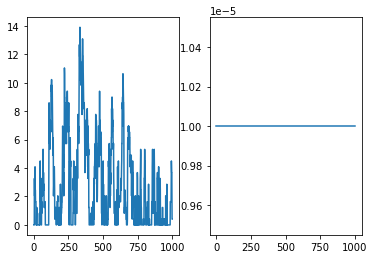

maximum steps, simulation is done ... 
elapsed_time: 51.287
Episode: 161 Exploration P: 0.0543 Total reward: -112.0781457977428 SOC: 0.5902 Cumulative_SOC_deviation: 16.8348 Fuel Consumption: 11.0694

maximum steps, simulation is done ... 
elapsed_time: 52.257
Episode: 162 Exploration P: 0.0534 Total reward: -334.8799477351896 SOC: 0.5186 Cumulative_SOC_deviation: 54.6838 Fuel Consumption: 6.7771

maximum steps, simulation is done ... 
elapsed_time: 52.050
Episode: 163 Exploration P: 0.0526 Total reward: -410.7574425740823 SOC: 0.5052 Cumulative_SOC_deviation: 67.0515 Fuel Consumption: 8.4486

maximum steps, simulation is done ... 
elapsed_time: 52.469
Episode: 164 Exploration P: 0.0517 Total reward: -102.69323872561893 SOC: 0.5970 Cumulative_SOC_deviation: 15.5080 Fuel Consumption: 9.6455

maximum steps, simulation is done ... 
elapsed_time: 52.031
Episode: 165 Exploration P: 0.0509 Total reward: -208.94467981773894 SOC: 0.4606 Cumulative_SOC_deviation: 33.5536 Fuel Consumption: 7.623

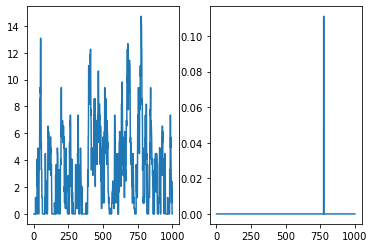

maximum steps, simulation is done ... 
elapsed_time: 51.440
Episode: 171 Exploration P: 0.0463 Total reward: -396.1512627884109 SOC: 0.4303 Cumulative_SOC_deviation: 65.1141 Fuel Consumption: 5.4667

maximum steps, simulation is done ... 
elapsed_time: 51.889
Episode: 172 Exploration P: 0.0455 Total reward: -99.71181272700196 SOC: 0.5668 Cumulative_SOC_deviation: 15.3825 Fuel Consumption: 7.4168

maximum steps, simulation is done ... 
elapsed_time: 52.228
Episode: 173 Exploration P: 0.0448 Total reward: -116.2741445399487 SOC: 0.5731 Cumulative_SOC_deviation: 18.1033 Fuel Consumption: 7.6541

maximum steps, simulation is done ... 
elapsed_time: 52.047
Episode: 174 Exploration P: 0.0441 Total reward: -127.52822297532443 SOC: 0.5618 Cumulative_SOC_deviation: 19.6884 Fuel Consumption: 9.3979

maximum steps, simulation is done ... 
elapsed_time: 51.985
Episode: 175 Exploration P: 0.0435 Total reward: -259.5038502793558 SOC: 0.5294 Cumulative_SOC_deviation: 42.0867 Fuel Consumption: 6.9834


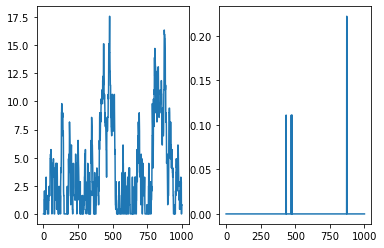

maximum steps, simulation is done ... 
elapsed_time: 51.541
Episode: 181 Exploration P: 0.0397 Total reward: -27.119510366447138 SOC: 0.5960 Cumulative_SOC_deviation: 3.4300 Fuel Consumption: 6.5397

maximum steps, simulation is done ... 
elapsed_time: 52.027
Episode: 182 Exploration P: 0.0391 Total reward: -1049.1159440772078 SOC: 0.3262 Cumulative_SOC_deviation: 172.9321 Fuel Consumption: 11.5234

maximum steps, simulation is done ... 
elapsed_time: 52.573
Episode: 183 Exploration P: 0.0385 Total reward: -84.53011234813835 SOC: 0.5918 Cumulative_SOC_deviation: 12.8127 Fuel Consumption: 7.6541

maximum steps, simulation is done ... 
elapsed_time: 52.328
Episode: 184 Exploration P: 0.0380 Total reward: -114.4674814107378 SOC: 0.5644 Cumulative_SOC_deviation: 18.0585 Fuel Consumption: 6.1167

maximum steps, simulation is done ... 
elapsed_time: 52.534
Episode: 185 Exploration P: 0.0374 Total reward: -350.70512773130156 SOC: 0.5146 Cumulative_SOC_deviation: 57.5243 Fuel Consumption: 5.55

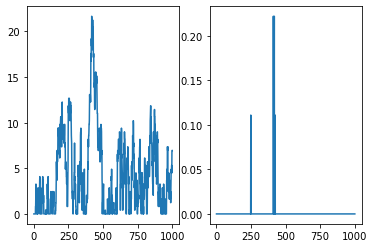

maximum steps, simulation is done ... 
elapsed_time: 51.565
Episode: 191 Exploration P: 0.0343 Total reward: -156.88896955824092 SOC: 0.5647 Cumulative_SOC_deviation: 25.2147 Fuel Consumption: 5.6008

maximum steps, simulation is done ... 
elapsed_time: 52.375
Episode: 192 Exploration P: 0.0338 Total reward: -247.866889908289 SOC: 0.5305 Cumulative_SOC_deviation: 40.5118 Fuel Consumption: 4.7960

maximum steps, simulation is done ... 
elapsed_time: 52.194
Episode: 193 Exploration P: 0.0333 Total reward: -261.01450873485743 SOC: 0.5260 Cumulative_SOC_deviation: 42.2628 Fuel Consumption: 7.4374

maximum steps, simulation is done ... 
elapsed_time: 52.117
Episode: 194 Exploration P: 0.0329 Total reward: -1322.8924716122108 SOC: 0.2760 Cumulative_SOC_deviation: 218.8332 Fuel Consumption: 9.8931

maximum steps, simulation is done ... 
elapsed_time: 51.696
Episode: 195 Exploration P: 0.0324 Total reward: -587.3619656155399 SOC: 0.4733 Cumulative_SOC_deviation: 97.0410 Fuel Consumption: 5.115

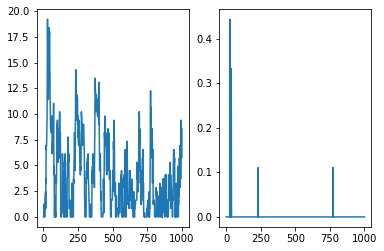

maximum steps, simulation is done ... 
elapsed_time: 51.609
Episode: 201 Exploration P: 0.0299 Total reward: -122.76070075443512 SOC: 0.5752 Cumulative_SOC_deviation: 19.6505 Fuel Consumption: 4.8579

maximum steps, simulation is done ... 
elapsed_time: 52.268
Episode: 202 Exploration P: 0.0295 Total reward: -444.04254511513005 SOC: 0.4448 Cumulative_SOC_deviation: 73.2955 Fuel Consumption: 4.2698

maximum steps, simulation is done ... 
elapsed_time: 52.125
Episode: 203 Exploration P: 0.0291 Total reward: -170.93128642727456 SOC: 0.5284 Cumulative_SOC_deviation: 27.7339 Fuel Consumption: 4.5277

maximum steps, simulation is done ... 
elapsed_time: 52.470
Episode: 204 Exploration P: 0.0287 Total reward: -425.64407469570045 SOC: 0.4820 Cumulative_SOC_deviation: 70.1603 Fuel Consumption: 4.6825

maximum steps, simulation is done ... 
elapsed_time: 52.502
Episode: 205 Exploration P: 0.0284 Total reward: -500.644077693495 SOC: 0.4624 Cumulative_SOC_deviation: 82.8185 Fuel Consumption: 3.733

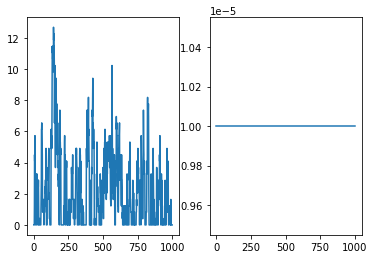

maximum steps, simulation is done ... 
elapsed_time: 51.415
Episode: 211 Exploration P: 0.0264 Total reward: -279.7472377614273 SOC: 0.4873 Cumulative_SOC_deviation: 45.8630 Fuel Consumption: 4.5690

maximum steps, simulation is done ... 
elapsed_time: 52.338
Episode: 212 Exploration P: 0.0261 Total reward: -657.3505679349523 SOC: 0.3939 Cumulative_SOC_deviation: 108.5648 Fuel Consumption: 5.9619

maximum steps, simulation is done ... 
elapsed_time: 52.052
Episode: 213 Exploration P: 0.0257 Total reward: -354.2528043536266 SOC: 0.4559 Cumulative_SOC_deviation: 58.2445 Fuel Consumption: 4.7857

maximum steps, simulation is done ... 
elapsed_time: 52.438
Episode: 214 Exploration P: 0.0254 Total reward: -197.62347753721846 SOC: 0.5608 Cumulative_SOC_deviation: 32.2531 Fuel Consumption: 4.1047

maximum steps, simulation is done ... 
elapsed_time: 52.286
Episode: 215 Exploration P: 0.0251 Total reward: -242.30785133548775 SOC: 0.5263 Cumulative_SOC_deviation: 39.6352 Fuel Consumption: 4.496

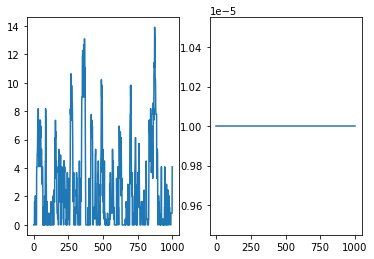

maximum steps, simulation is done ... 
elapsed_time: 51.738
Episode: 221 Exploration P: 0.0234 Total reward: -329.38687763967386 SOC: 0.4625 Cumulative_SOC_deviation: 54.3719 Fuel Consumption: 3.1554

maximum steps, simulation is done ... 
elapsed_time: 52.319
Episode: 222 Exploration P: 0.0231 Total reward: -294.9845654670595 SOC: 0.4846 Cumulative_SOC_deviation: 48.8463 Fuel Consumption: 1.9069

maximum steps, simulation is done ... 
elapsed_time: 52.265
Episode: 223 Exploration P: 0.0229 Total reward: -631.9362875005617 SOC: 0.4135 Cumulative_SOC_deviation: 104.6782 Fuel Consumption: 3.8673

maximum steps, simulation is done ... 
elapsed_time: 52.266
Episode: 224 Exploration P: 0.0226 Total reward: -288.3531935398214 SOC: 0.4500 Cumulative_SOC_deviation: 47.2888 Fuel Consumption: 4.6206

maximum steps, simulation is done ... 
elapsed_time: 52.511
Episode: 225 Exploration P: 0.0224 Total reward: -207.72909866132454 SOC: 0.3270 Cumulative_SOC_deviation: 33.3974 Fuel Consumption: 7.344

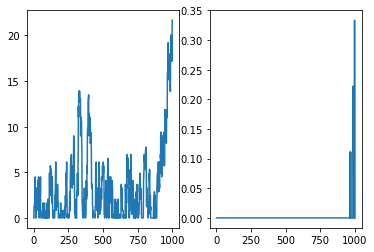

maximum steps, simulation is done ... 
elapsed_time: 52.102
Episode: 231 Exploration P: 0.0210 Total reward: -459.9108592471638 SOC: 0.3434 Cumulative_SOC_deviation: 75.3452 Fuel Consumption: 7.8398

maximum steps, simulation is done ... 
elapsed_time: 52.258
Episode: 232 Exploration P: 0.0208 Total reward: -1037.9923057276114 SOC: 0.3425 Cumulative_SOC_deviation: 172.0326 Fuel Consumption: 5.7968

maximum steps, simulation is done ... 
elapsed_time: 52.184
Episode: 233 Exploration P: 0.0205 Total reward: -363.266515329217 SOC: 0.4600 Cumulative_SOC_deviation: 59.7829 Fuel Consumption: 4.5690

maximum steps, simulation is done ... 
elapsed_time: 52.589
Episode: 234 Exploration P: 0.0203 Total reward: -227.86947284054273 SOC: 0.5447 Cumulative_SOC_deviation: 37.2339 Fuel Consumption: 4.4658

maximum steps, simulation is done ... 
elapsed_time: 52.399
Episode: 235 Exploration P: 0.0201 Total reward: -213.16131506858483 SOC: 0.5278 Cumulative_SOC_deviation: 34.9872 Fuel Consumption: 3.237

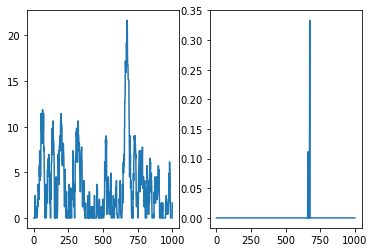

maximum steps, simulation is done ... 
elapsed_time: 51.475
Episode: 241 Exploration P: 0.0190 Total reward: -310.296241885405 SOC: 0.5045 Cumulative_SOC_deviation: 51.0543 Fuel Consumption: 3.9705

maximum steps, simulation is done ... 
elapsed_time: 52.359
Episode: 242 Exploration P: 0.0188 Total reward: -716.1204074155402 SOC: 0.3937 Cumulative_SOC_deviation: 118.5575 Fuel Consumption: 4.7753

maximum steps, simulation is done ... 
elapsed_time: 52.528
Episode: 243 Exploration P: 0.0186 Total reward: -223.84149196969915 SOC: 0.5389 Cumulative_SOC_deviation: 36.8618 Fuel Consumption: 2.6704

maximum steps, simulation is done ... 
elapsed_time: 52.196
Episode: 244 Exploration P: 0.0185 Total reward: -563.7165186058236 SOC: 0.4035 Cumulative_SOC_deviation: 93.1087 Fuel Consumption: 5.0643

maximum steps, simulation is done ... 
elapsed_time: 52.198
Episode: 245 Exploration P: 0.0183 Total reward: -821.0088714499568 SOC: 0.3955 Cumulative_SOC_deviation: 136.4534 Fuel Consumption: 2.2887

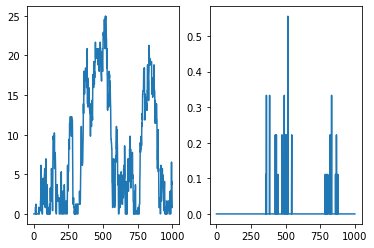

maximum steps, simulation is done ... 
elapsed_time: 51.571
Episode: 251 Exploration P: 0.0174 Total reward: -324.93024376422346 SOC: 0.4843 Cumulative_SOC_deviation: 53.6876 Fuel Consumption: 2.8046

maximum steps, simulation is done ... 
elapsed_time: 52.162
Episode: 252 Exploration P: 0.0172 Total reward: -416.7667186213337 SOC: 0.4030 Cumulative_SOC_deviation: 68.5586 Fuel Consumption: 5.4151

maximum steps, simulation is done ... 
elapsed_time: 52.162
Episode: 253 Exploration P: 0.0171 Total reward: -653.0471262872921 SOC: 0.4150 Cumulative_SOC_deviation: 108.1708 Fuel Consumption: 4.0221

maximum steps, simulation is done ... 
elapsed_time: 52.259
Episode: 254 Exploration P: 0.0169 Total reward: -410.0151161395631 SOC: 0.4552 Cumulative_SOC_deviation: 67.8306 Fuel Consumption: 3.0316

maximum steps, simulation is done ... 
elapsed_time: 52.394
Episode: 255 Exploration P: 0.0168 Total reward: -300.97506711232717 SOC: 0.4852 Cumulative_SOC_deviation: 49.6315 Fuel Consumption: 3.186

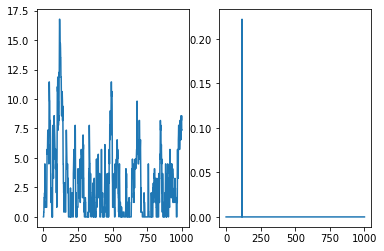

maximum steps, simulation is done ... 
elapsed_time: 51.428
Episode: 261 Exploration P: 0.0160 Total reward: -268.58427120802344 SOC: 0.4613 Cumulative_SOC_deviation: 44.4170 Fuel Consumption: 2.0823

maximum steps, simulation is done ... 
elapsed_time: 52.145
Episode: 262 Exploration P: 0.0159 Total reward: -361.7239032234242 SOC: 0.3775 Cumulative_SOC_deviation: 59.3745 Fuel Consumption: 5.4770

maximum steps, simulation is done ... 
elapsed_time: 52.042
Episode: 263 Exploration P: 0.0158 Total reward: -787.0542519266193 SOC: 0.4020 Cumulative_SOC_deviation: 130.8149 Fuel Consumption: 2.1649

maximum steps, simulation is done ... 
elapsed_time: 52.243
Episode: 264 Exploration P: 0.0157 Total reward: -286.81693797043624 SOC: 0.2727 Cumulative_SOC_deviation: 46.2503 Fuel Consumption: 9.3153

maximum steps, simulation is done ... 
elapsed_time: 52.126
Episode: 265 Exploration P: 0.0156 Total reward: -231.2724739393071 SOC: 0.5352 Cumulative_SOC_deviation: 38.0040 Fuel Consumption: 3.248

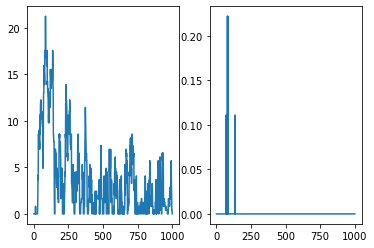

maximum steps, simulation is done ... 
elapsed_time: 50.938
Episode: 271 Exploration P: 0.0149 Total reward: -177.1792670108231 SOC: 0.5207 Cumulative_SOC_deviation: 29.2568 Fuel Consumption: 1.6386

maximum steps, simulation is done ... 
elapsed_time: 51.994
Episode: 272 Exploration P: 0.0148 Total reward: -461.5437211439353 SOC: 0.4237 Cumulative_SOC_deviation: 76.0696 Fuel Consumption: 5.1262

maximum steps, simulation is done ... 
elapsed_time: 52.080
Episode: 273 Exploration P: 0.0147 Total reward: -295.5924644277446 SOC: 0.5163 Cumulative_SOC_deviation: 48.6948 Fuel Consumption: 3.4237

maximum steps, simulation is done ... 
elapsed_time: 51.876
Episode: 274 Exploration P: 0.0146 Total reward: -230.9112727080607 SOC: 0.5193 Cumulative_SOC_deviation: 38.1536 Fuel Consumption: 1.9894

maximum steps, simulation is done ... 
elapsed_time: 51.893
Episode: 275 Exploration P: 0.0146 Total reward: -277.1200586174835 SOC: 0.5108 Cumulative_SOC_deviation: 45.8173 Fuel Consumption: 2.2164



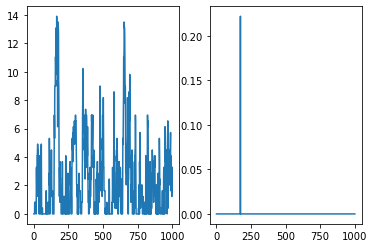

maximum steps, simulation is done ... 
elapsed_time: 51.438
Episode: 281 Exploration P: 0.0140 Total reward: -926.287893533037 SOC: 0.2453 Cumulative_SOC_deviation: 153.3154 Fuel Consumption: 6.3953

maximum steps, simulation is done ... 
elapsed_time: 51.986
Episode: 282 Exploration P: 0.0140 Total reward: -379.9093647579748 SOC: 0.4647 Cumulative_SOC_deviation: 62.7854 Fuel Consumption: 3.1967

maximum steps, simulation is done ... 
elapsed_time: 52.021
Episode: 283 Exploration P: 0.0139 Total reward: -560.7327726162139 SOC: 0.3986 Cumulative_SOC_deviation: 92.7404 Fuel Consumption: 4.2904

maximum steps, simulation is done ... 
elapsed_time: 52.339
Episode: 284 Exploration P: 0.0138 Total reward: -240.18985920122498 SOC: 0.5024 Cumulative_SOC_deviation: 39.7310 Fuel Consumption: 1.8037

maximum steps, simulation is done ... 
elapsed_time: 52.150
Episode: 285 Exploration P: 0.0137 Total reward: -370.8028805738367 SOC: 0.4939 Cumulative_SOC_deviation: 61.6598 Fuel Consumption: 0.8441


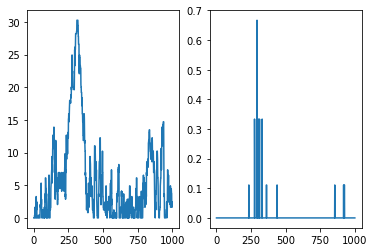

maximum steps, simulation is done ... 
elapsed_time: 51.127
Episode: 291 Exploration P: 0.0133 Total reward: -389.78769238584266 SOC: 0.4621 Cumulative_SOC_deviation: 64.6279 Fuel Consumption: 2.0204

maximum steps, simulation is done ... 
elapsed_time: 52.334
Episode: 292 Exploration P: 0.0132 Total reward: -253.60091835004926 SOC: 0.5124 Cumulative_SOC_deviation: 41.9404 Fuel Consumption: 1.9585

maximum steps, simulation is done ... 
elapsed_time: 52.390
Episode: 293 Exploration P: 0.0132 Total reward: -234.1563437524794 SOC: 0.4850 Cumulative_SOC_deviation: 38.7616 Fuel Consumption: 1.5870

maximum steps, simulation is done ... 
elapsed_time: 51.974
Episode: 294 Exploration P: 0.0131 Total reward: -641.6878196726994 SOC: 0.3900 Cumulative_SOC_deviation: 106.5115 Fuel Consumption: 2.6189

maximum steps, simulation is done ... 
elapsed_time: 52.209
Episode: 295 Exploration P: 0.0130 Total reward: -233.59158920770304 SOC: 0.5178 Cumulative_SOC_deviation: 38.5109 Fuel Consumption: 2.52

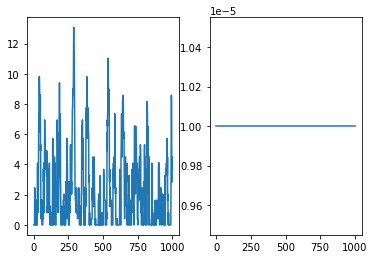

maximum steps, simulation is done ... 
elapsed_time: 51.320
Episode: 301 Exploration P: 0.0127 Total reward: -1143.3843224066231 SOC: 0.3377 Cumulative_SOC_deviation: 190.0227 Fuel Consumption: 3.2483

maximum steps, simulation is done ... 
elapsed_time: 52.024
Episode: 302 Exploration P: 0.0127 Total reward: -293.49746406011724 SOC: 0.5103 Cumulative_SOC_deviation: 48.6191 Fuel Consumption: 1.7831

maximum steps, simulation is done ... 
elapsed_time: 52.192
Episode: 303 Exploration P: 0.0126 Total reward: -319.9892943013634 SOC: 0.4824 Cumulative_SOC_deviation: 53.1444 Fuel Consumption: 1.1227

maximum steps, simulation is done ... 
elapsed_time: 52.291
Episode: 304 Exploration P: 0.0125 Total reward: -296.92530859596565 SOC: 0.5124 Cumulative_SOC_deviation: 49.2024 Fuel Consumption: 1.7109

maximum steps, simulation is done ... 
elapsed_time: 51.929
Episode: 305 Exploration P: 0.0125 Total reward: -199.29420239413213 SOC: 0.5082 Cumulative_SOC_deviation: 32.9357 Fuel Consumption: 1.6

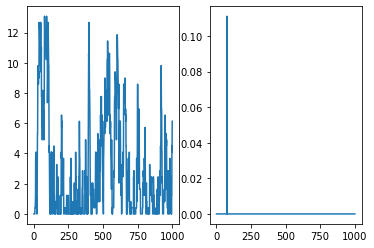

maximum steps, simulation is done ... 
elapsed_time: 51.538
Episode: 311 Exploration P: 0.0122 Total reward: -387.95950589055786 SOC: 0.4764 Cumulative_SOC_deviation: 64.5760 Fuel Consumption: 0.5036

maximum steps, simulation is done ... 
elapsed_time: 51.854
Episode: 312 Exploration P: 0.0122 Total reward: -232.22465925695502 SOC: 0.5116 Cumulative_SOC_deviation: 38.3915 Fuel Consumption: 1.8759

maximum steps, simulation is done ... 
elapsed_time: 52.288
Episode: 313 Exploration P: 0.0121 Total reward: -289.4293136556284 SOC: 0.4885 Cumulative_SOC_deviation: 47.8000 Fuel Consumption: 2.6292

maximum steps, simulation is done ... 
elapsed_time: 51.980
Episode: 314 Exploration P: 0.0121 Total reward: -225.4321569978022 SOC: 0.5232 Cumulative_SOC_deviation: 37.2490 Fuel Consumption: 1.9379

maximum steps, simulation is done ... 
elapsed_time: 52.274
Episode: 315 Exploration P: 0.0120 Total reward: -656.8688533776088 SOC: 0.4170 Cumulative_SOC_deviation: 108.6031 Fuel Consumption: 5.250

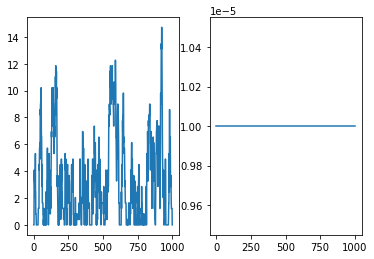

maximum steps, simulation is done ... 
elapsed_time: 51.266
Episode: 321 Exploration P: 0.0118 Total reward: -346.8637342185369 SOC: 0.4525 Cumulative_SOC_deviation: 57.5048 Fuel Consumption: 1.8347

maximum steps, simulation is done ... 
elapsed_time: 51.945
Episode: 322 Exploration P: 0.0118 Total reward: -196.33014601345616 SOC: 0.5138 Cumulative_SOC_deviation: 32.2990 Fuel Consumption: 2.5363

maximum steps, simulation is done ... 
elapsed_time: 52.140
Episode: 323 Exploration P: 0.0117 Total reward: -403.5574147269954 SOC: 0.4736 Cumulative_SOC_deviation: 66.9142 Fuel Consumption: 2.0720

maximum steps, simulation is done ... 
elapsed_time: 52.165
Episode: 324 Exploration P: 0.0117 Total reward: -278.5496057783448 SOC: 0.5186 Cumulative_SOC_deviation: 46.1088 Fuel Consumption: 1.8966

maximum steps, simulation is done ... 
elapsed_time: 52.119
Episode: 325 Exploration P: 0.0117 Total reward: -486.2623613541816 SOC: 0.3966 Cumulative_SOC_deviation: 80.4490 Fuel Consumption: 3.5681


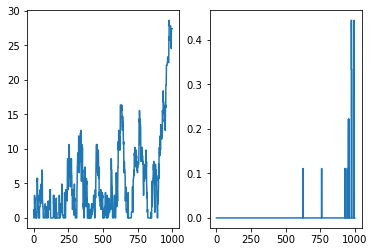

maximum steps, simulation is done ... 
elapsed_time: 51.707
Episode: 331 Exploration P: 0.0115 Total reward: -224.82350184653308 SOC: 0.5154 Cumulative_SOC_deviation: 37.2491 Fuel Consumption: 1.3291

maximum steps, simulation is done ... 
elapsed_time: 52.164
Episode: 332 Exploration P: 0.0115 Total reward: -380.1526357180416 SOC: 0.4717 Cumulative_SOC_deviation: 63.0668 Fuel Consumption: 1.7521

maximum steps, simulation is done ... 
elapsed_time: 52.233
Episode: 333 Exploration P: 0.0114 Total reward: -287.2255905506023 SOC: 0.5214 Cumulative_SOC_deviation: 47.4964 Fuel Consumption: 2.2474

maximum steps, simulation is done ... 
elapsed_time: 52.260
Episode: 334 Exploration P: 0.0114 Total reward: -213.92682104066128 SOC: 0.5068 Cumulative_SOC_deviation: 35.3005 Fuel Consumption: 2.1236

maximum steps, simulation is done ... 
elapsed_time: 52.044
Episode: 335 Exploration P: 0.0114 Total reward: -235.8714180192368 SOC: 0.5250 Cumulative_SOC_deviation: 39.1678 Fuel Consumption: 0.8648

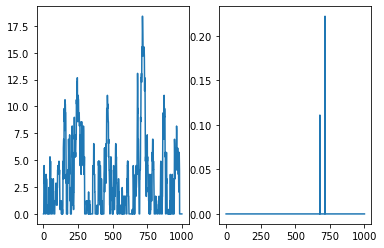

maximum steps, simulation is done ... 
elapsed_time: 51.070
Episode: 341 Exploration P: 0.0112 Total reward: -316.97207054036403 SOC: 0.4761 Cumulative_SOC_deviation: 52.5779 Fuel Consumption: 1.5045

maximum steps, simulation is done ... 
elapsed_time: 52.236
Episode: 342 Exploration P: 0.0112 Total reward: -272.75098777104523 SOC: 0.4945 Cumulative_SOC_deviation: 45.1407 Fuel Consumption: 1.9069

maximum steps, simulation is done ... 
elapsed_time: 51.561
Episode: 343 Exploration P: 0.0112 Total reward: -341.3625479380258 SOC: 0.4776 Cumulative_SOC_deviation: 56.4779 Fuel Consumption: 2.4950

maximum steps, simulation is done ... 
elapsed_time: 51.890
Episode: 344 Exploration P: 0.0111 Total reward: -217.42358422871342 SOC: 0.5039 Cumulative_SOC_deviation: 35.8816 Fuel Consumption: 2.1339

maximum steps, simulation is done ... 
elapsed_time: 52.323
Episode: 345 Exploration P: 0.0111 Total reward: -236.39809699844304 SOC: 0.5131 Cumulative_SOC_deviation: 39.2091 Fuel Consumption: 1.14

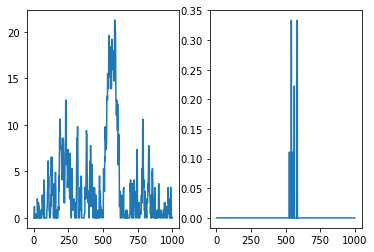

maximum steps, simulation is done ... 
elapsed_time: 51.539
Episode: 351 Exploration P: 0.0110 Total reward: -370.47464477023397 SOC: 0.4827 Cumulative_SOC_deviation: 61.4211 Fuel Consumption: 1.9482

maximum steps, simulation is done ... 
elapsed_time: 51.840
Episode: 352 Exploration P: 0.0110 Total reward: -458.9152494780884 SOC: 0.4695 Cumulative_SOC_deviation: 76.2110 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 51.946
Episode: 353 Exploration P: 0.0110 Total reward: -359.25485703954456 SOC: 0.5079 Cumulative_SOC_deviation: 59.6457 Fuel Consumption: 1.3807

maximum steps, simulation is done ... 
elapsed_time: 52.368
Episode: 354 Exploration P: 0.0109 Total reward: -627.8150353153244 SOC: 0.4426 Cumulative_SOC_deviation: 104.3387 Fuel Consumption: 1.7831

maximum steps, simulation is done ... 
elapsed_time: 52.121
Episode: 355 Exploration P: 0.0109 Total reward: -659.4271403668307 SOC: 0.3951 Cumulative_SOC_deviation: 109.2342 Fuel Consumption: 4.02

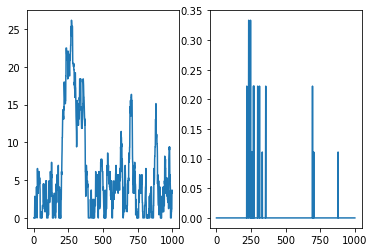

maximum steps, simulation is done ... 
elapsed_time: 51.299
Episode: 361 Exploration P: 0.0108 Total reward: -277.98058508287556 SOC: 0.5081 Cumulative_SOC_deviation: 46.0862 Fuel Consumption: 1.4632

maximum steps, simulation is done ... 
elapsed_time: 52.282
Episode: 362 Exploration P: 0.0108 Total reward: -565.6455456230943 SOC: 0.2348 Cumulative_SOC_deviation: 92.8180 Fuel Consumption: 8.7375

maximum steps, simulation is done ... 
elapsed_time: 52.100
Episode: 363 Exploration P: 0.0108 Total reward: -195.2180219706742 SOC: 0.5028 Cumulative_SOC_deviation: 32.0311 Fuel Consumption: 3.0316

maximum steps, simulation is done ... 
elapsed_time: 51.744
Episode: 364 Exploration P: 0.0108 Total reward: -570.753944485319 SOC: 0.4414 Cumulative_SOC_deviation: 94.5722 Fuel Consumption: 3.3205

maximum steps, simulation is done ... 
elapsed_time: 52.486
Episode: 365 Exploration P: 0.0108 Total reward: -165.54767496610518 SOC: 0.5294 Cumulative_SOC_deviation: 27.3801 Fuel Consumption: 1.2672


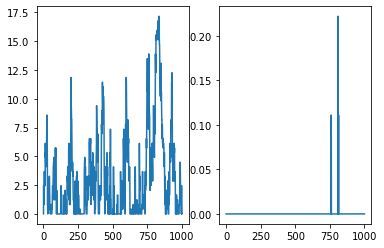

maximum steps, simulation is done ... 
elapsed_time: 51.550
Episode: 371 Exploration P: 0.0107 Total reward: -236.4600246325341 SOC: 0.4508 Cumulative_SOC_deviation: 38.9598 Fuel Consumption: 2.7014

maximum steps, simulation is done ... 
elapsed_time: 52.110
Episode: 372 Exploration P: 0.0107 Total reward: -716.7458476663163 SOC: 0.3788 Cumulative_SOC_deviation: 119.0968 Fuel Consumption: 2.1649

maximum steps, simulation is done ... 
elapsed_time: 51.858
Episode: 373 Exploration P: 0.0106 Total reward: -1724.5597006177945 SOC: 0.2179 Cumulative_SOC_deviation: 285.8930 Fuel Consumption: 9.2018

battery power is 126009.82120804657(+) but condition is not avail
elapsed_time: 23.881
Episode: 374 Exploration P: 0.0106 Total reward: -1047.1213889971284 SOC: 0.5054 Cumulative_SOC_deviation: 7.6019 Fuel Consumption: 2.0778

maximum steps, simulation is done ... 
elapsed_time: 52.325
Episode: 375 Exploration P: 0.0106 Total reward: -230.0621164832558 SOC: 0.4896 Cumulative_SOC_deviation: 38.2

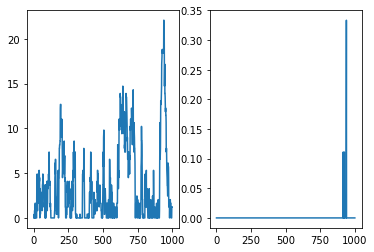

maximum steps, simulation is done ... 
elapsed_time: 52.381
Episode: 381 Exploration P: 0.0106 Total reward: -228.6156089104892 SOC: 0.4675 Cumulative_SOC_deviation: 37.9206 Fuel Consumption: 1.0918

maximum steps, simulation is done ... 
elapsed_time: 51.261
Episode: 382 Exploration P: 0.0105 Total reward: -538.0621195068128 SOC: 0.3066 Cumulative_SOC_deviation: 88.8622 Fuel Consumption: 4.8888

maximum steps, simulation is done ... 
elapsed_time: 52.355
Episode: 383 Exploration P: 0.0105 Total reward: -874.9596494205094 SOC: 0.2964 Cumulative_SOC_deviation: 144.7143 Fuel Consumption: 6.6739

maximum steps, simulation is done ... 
elapsed_time: 51.957
Episode: 384 Exploration P: 0.0105 Total reward: -616.8520968910861 SOC: 0.4360 Cumulative_SOC_deviation: 102.5906 Fuel Consumption: 1.3085

maximum steps, simulation is done ... 
elapsed_time: 51.883
Episode: 385 Exploration P: 0.0105 Total reward: -244.63626102322846 SOC: 0.5301 Cumulative_SOC_deviation: 40.5323 Fuel Consumption: 1.442

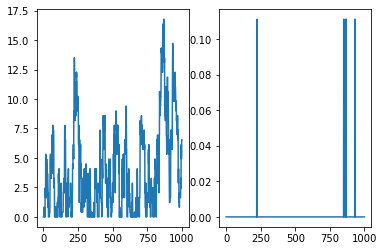

maximum steps, simulation is done ... 
elapsed_time: 52.592
Episode: 391 Exploration P: 0.0105 Total reward: -185.7663100262097 SOC: 0.5492 Cumulative_SOC_deviation: 30.6897 Fuel Consumption: 1.6283

maximum steps, simulation is done ... 
elapsed_time: 51.605
Episode: 392 Exploration P: 0.0104 Total reward: -341.857812266743 SOC: 0.4737 Cumulative_SOC_deviation: 56.6430 Fuel Consumption: 1.9998

maximum steps, simulation is done ... 
elapsed_time: 52.175
Episode: 393 Exploration P: 0.0104 Total reward: -337.2970901566089 SOC: 0.4379 Cumulative_SOC_deviation: 55.9500 Fuel Consumption: 1.5974

maximum steps, simulation is done ... 
elapsed_time: 52.101
Episode: 394 Exploration P: 0.0104 Total reward: -402.31575479369155 SOC: 0.4926 Cumulative_SOC_deviation: 66.4253 Fuel Consumption: 3.7642

maximum steps, simulation is done ... 
elapsed_time: 52.116
Episode: 395 Exploration P: 0.0104 Total reward: -519.8275024786464 SOC: 0.4428 Cumulative_SOC_deviation: 86.2754 Fuel Consumption: 2.1752



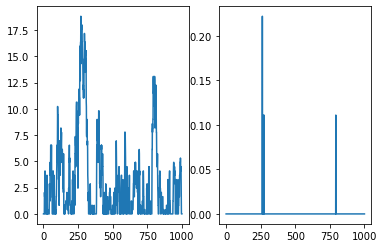

model is saved..


In [15]:
# print(env.version)

# num_trials = 1
reward_factors = [4, 5, 6]
results_dict = {} 

for reward_factor in reward_factors: 
    print("")
    print("Trial {}".format(reward_factor))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, reward_factor)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, reward_factor)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
#         if (ep + 1) % 200 == 0:             
    root = "DDPG_MDP_reward_factor{}".format(reward_factor)
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
            
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_MDP_4to6.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict